### Week 1 Final Project ###

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.gridspec as gridspec
from matplotlib.animation import PillowWriter
from IPython.display import Image
import plotly.graph_objects as go

**Non Dimensionalization**

To start, ND the equations mentioned in the proposal. The time scale I chose to use was $\sqrt(\frac{m}{k})$ and the length scale I will use is l.

$\tau = \frac{t}{T}, T = \sqrt{\frac{m}{k}}$ and $\hat{r} = \frac{r}{l}$

substituting these in to ND our original equations we get:

$\frac{1}{T^2}\frac{d^2\theta}{d\tau^2} = (\frac{-g}{l\hat{r}})sin(\theta) - \frac{2l}{T^2l\hat{r}}\frac{d\theta}{d\tau}\frac{d\hat{r}}{d\tau}$ simplifying we get $\frac{d^2\theta}{d\tau^2} = -(\frac{gm}{kl})\frac{1}{\hat{r}}sin(\theta) - \frac{2}{\hat{r}}\frac{d\theta}{d\tau}\frac{d\hat{r}}{d\tau}$

Next, we can substitute into the other differential equation to get $\frac{l}{T^2}\frac{d^2\hat{r}}{d\tau^2} = l\hat{r}\frac{1}{T^2}(\frac{d\theta}{d\tau})^2 + \frac{k}{m}(l - l\hat{r}) + gcos(\theta)$ simplifying we get $\frac{d^2\hat{r}}{d\tau^2} = \hat{r}(\frac{d\theta}{d\tau})^2 + (1 - \hat{r}) + \frac{gm}{kl}cos(\theta)$

From these two ND equations we can then define a constant 
$\gamma = \frac{gm}{kl}$ which we can describe as controlling the relative importance of gravity to the spring force in the system.  

**Damping and Driving Forces**

To add damping, we can first observe that is usually though of as proportional to the velocity. In this case, we have radial and angulur velocity so we should have one damping force for each. To do this, we can define some constant $C$ to determine the magnitude of each of these damping forces. 

This allows us to modify our differential equations as follows:
$$\theta'' = \frac{-g}{r}sin(\theta) - \frac{2r'}{r}\theta' - C_1\theta'$$
$$r'' = r\theta'^2 + \frac{k}{m}(l - r) + gcos(\theta) - C_2r'$$

Next, to add a driving force to the system we can follow a similar procedure. Its important to note that I will be using a sinusoidal driving force which is subject to change in later iterations of this project. $\omega_{r}$ and $\omega_{\theta}$ represent how quickly the driving force oscillates and $F_o$ represents the magnitude of the driving force.

$$\theta'' = \frac{-g}{r}sin(\theta) - \frac{2r'}{r}\theta' - C_1\theta' + F_ocos(\omega_{\theta}t)$$
$$r'' = r\theta'^2 + \frac{k}{m}(l - r) + gcos(\theta) - C_2r' + F_ocos(\omega_{r}t)$$

To convert these driving + damping equations into dimensionless equations we can simply redifine each of the respective damping and driving components to be proportional to the non dimensionalized variables giving us the final differential equations:

$$\frac{d^2\hat{r}}{d\tau^2} = \hat{r}(\frac{d\theta}{d\tau})^2 + (1 - \hat{r}) + \gamma cos(\theta) - C_2\frac{d\hat{r}}{d\tau} + F_ocos(\omega_{\hat{r}}\tau)$$
$$\frac{d^2\theta}{d\tau^2} = -(\gamma)\frac{1}{\hat{r}}sin(\theta) - \frac{2}{\hat{r}}\theta'\frac{d\hat{r}}{d\tau} - C_1\frac{d\theta}{d\tau} + F_ocos(\omega_{\theta}\tau)$$

Where $C_1, C_2$ still represent the magnitude of the damping and $\omega_{\hat{r}}, \omega_{\theta}$ still represents how quickly the driving force oscillates and $F_o$ still represents the magnitude of the driving force.

Firstly, in terms of special cases, it might be easier to think about the special cases where there is no driving or damping.

1. 
Of the no damping or driving cases, when $r = 1$ (spring is at equilibrium), and everything else = 0 (no initial radial or angular velocity and spring is hanging vertically), we know that the only factor causing any variation in the data should be $\gamma$. When $\gamma$ is larger, we should expect more oscillations in the length of the spring with a greater amplitude where the spring oscillates back and forth from equilibrium.

$$0 = \theta, v_o, \Theta_o$$
$$1 = \hat{r_o}$$

2. 
Next, we know that without driving or damping, when the radius is $\approx$ 1, and $\theta_o$ is small, we know that the mass will swing back and forth like a simple pendulum with an approximately fixed radius. The spring stretches slightly due to the gravitational force, but the radial oscillation is small, leading to a mostly angular, swinging motion.

### Before Plugging into Numerical Methods ###

As a quick preface to the numerical work, we must first turn these equations into first order differential equations by defining
initial conditions $\vec{f} = [\hat{r_o}, \theta, v_o, \Theta_o]$
where $v = \frac{dr}{d\tau}$ and $\Theta = \frac{dr\theta}{d\tau}$
giving us:
$$\frac{df_2}{d\tau} = f_o(f_3)^2 + (1 - f_o) + \gamma cos(f_1) - C_2f_2 + F_2cos(\omega_{\hat{r}}\tau)$$
$$\frac{df_3}{d\tau} = -(\gamma)\frac{1}{f_o}sin(f_1) - \frac{2}{f_o}f_2f_3 - C_1f_3 + F_1cos(\omega_{\theta}\tau)$$

### RK4 ###

In [33]:
def rk4(function, x_initial, step_size, step_count):
    """
    implementation of the midpoint RK method to differentials

    function : force function of two variables
    x_initial : the initial value x_o
    step_size : the time steps we are taking del_t
    step_count : total number of steps we are taking

    returns : two lists, one of the times and one of the x position of length N + 1
    """
    x_n = x_initial
    t_n = 0
    t_vals = np.linspace(0, step_size * step_count, step_count + 1)
    if isinstance(x_initial, (int, float)):
        x_vals = np.zeros(step_count + 1)  # For scalar x_initial, use a 1D array
    else:
        x_vals = np.zeros((step_count + 1, len(x_initial)))
    for i in range(step_count):
        k_1 = function(x_n, t_n) * step_size
        k_2 = function(x_n + (k_1/2), t_n + (step_size/2)) * step_size
        k_3 = function(x_n + (k_2/2), t_n + (step_size/2)) * step_size
        k_4 = function(x_n + k_3, t_n + (step_size)) * step_size
        x_n = x_n + (k_1/6) + (k_2/3) + (k_3/3) + (k_4/6)
        t_n += step_size
        t_vals[i + 1] = t_n
        x_vals[i + 1] = x_n
    return t_vals, x_vals

def elastic_pendulum_rk4(initial_conditions, step_size, step_count, gamma, C_1, C_2, F_1, F_2, omega_theta, omega_r):
    """
    solves the differential equations for length of spring as a function of time and angle formed with the vertical as a function of time

    initial_condition : array of initial conditions in the form 
    [r_0, initial radial velocity, theta_0, initial angular velocity]
    step_size : size of each time step del_t
    step_count : total number of steps that are being taken
    gamma : controls the relative importance of gravity to the spring force in the system.  
    C_1 : constant conrolling the magnitude of the damping angularly
    C_2 : constant conrolling the magnitude of the damping radially
    F_1 : constant controlling the magnitude of the driving force angularly
    F_2 : constant controlling the magnitude of the driving force radially
    omega_r : constant controlling how fast oscillations of the radial driving force occur
    omega_theta : constant controlling how fast oscillations of the angular driving force occur

    returns : the lengths of the spring [r] and the angle of the spring [theta]
    """
    def F(x, t):
        """
        the differential equations correspondign to randial and angular acceleration
    
        x : vector f = [r, theta, radial velocity, angular velocity]
        t : dimensionless time (tau)
    
        returns : vector corresponding to [radial velocity, angular velocity, radial acceleration, angular acceleration]
        """
        radial_acceleration = ((x[0]) * (x[3]**2)) + (1 - x[0]) + (gamma * np.cos(x[1])) - (C_2 * x[1]) + (F_2 * np.cos(omega_r * t))
        angular_acceleration = ((-gamma/x[0]) * np.sin(x[1])) - (2 * x[3] * x[2] / x[0]) - (C_1 * x[3]) + (F_1 * np.cos(omega_theta * t))
        return np.array([x[2], x[3], radial_acceleration, angular_acceleration])
    t_vals, f_vals = rk4(F, initial_conditions, step_size, step_count)
    r_vals = np.zeros(step_count + 1)
    theta_vals = np.zeros(step_count + 1)
    deriv_r_vals = np.zeros(step_count + 1)
    deriv_theta_vals = np.zeros(step_count + 1)
    for i in range(step_count + 1):
        r_vals[i] = f_vals[i][0]
        theta_vals[i] = f_vals[i][1]
        deriv_r_vals[i] = f_vals[i][2]
        deriv_theta_vals[i] = f_vals[i][3]
    return r_vals, theta_vals, deriv_r_vals, deriv_theta_vals

### Adams bashforth ###

In [35]:
def adams_bashforth(function, initial_f, step_size, step_count):
    """
    adams bashforth method

    function : differential equation function
    initial_f : initial value of target function
    step_size : step_size of each step
    step_count : number of time steps we are taking

    returns : list of times and list of numerical target function values
    """
    # create time list
    t_vals = np.linspace(0, step_count * step_size, step_count + 1)
    
    # get ready to enter loop
    if isinstance(initial_f, (int, float)):
        f_vals = np.zeros(step_count + 1)  # For scalar x_initial, use a 1D array
    else:
        f_vals = np.zeros((step_count + 1, len(initial_f)))
    f_vals[0] = initial_f

    # find first value in f_vals using rk4
    k_1 = function(f_vals[0], t_vals[0]) * step_size
    k_2 = function(f_vals[0] + (k_1/2), t_vals[0] + (step_size/2)) * step_size
    k_3 = function(f_vals[0] + (k_2/2), t_vals[0] + (step_size/2)) * step_size
    k_4 = function(f_vals[0] + k_3, t_vals[0] + (step_size)) * step_size
    f_vals[1] = f_vals[0] + (k_1/6) + (k_2/3) + (k_3/3) + (k_4/6)
    
    # loop to finish x vals list
    for i in range (1,step_count - 1):
        f_vals[i+1] = f_vals[i] + ((step_size / 2.0) * ((3 * function(f_vals[i], t_vals[i])) - function(f_vals[i-1], t_vals[i-1]))) 
    return t_vals, f_vals

In [37]:
def elastic_pendulum_bash(initial_conditions, step_size, step_count, gamma, C_1, C_2, F_1, F_2, omega_theta, omega_r):
    """
    solves the differential equations for length of spring as a function of time and angle formed with the vertical as a function of time

    initial_condition : array of initial conditions in the form 
    [r_0, initial radial velocity, theta_0, initial angular velocity]
    step_size : size of each time step del_t
    step_count : total number of steps that are being taken
    gamma : controls the relative importance of gravity to the spring force in the system.  
    C_1 : constant conrolling the magnitude of the damping angularly
    C_2 : constant conrolling the magnitude of the damping radially
    F_1 : constant controlling the magnitude of the driving force angularly
    F_2 : constant controlling the magnitude of the driving force radially
    omega_r : constant controlling how fast oscillations of the radial driving force occur
    omega_theta : constant controlling how fast oscillations of the angular driving force occur

    returns : the lengths of the spring [r] and the angles of the spring [theta]
    """
    def F(x, t):
        """
        the differential equations correspondign to randial and angular acceleration
    
        x : vector f = [r, theta, radial velocity, angular velocity]
        t : dimensionless time (tau)
    
        returns : vector corresponding to [radial velocity, angular velocity, radial acceleration, angular acceleration]
        """
        radial_acceleration = ((x[0]) * (x[3]**2)) + (1 - x[0]) + (gamma * np.cos(x[1])) - (C_2 * x[1]) + (F_2 * np.cos(omega_r * t))
        angular_acceleration = ((-gamma/x[0]) * np.sin(x[1])) - (2 * x[3] * x[2] / x[0]) - (C_1 * x[3]) + (F_1 * np.cos(omega_theta * t))
        return np.array([x[2], x[3], radial_acceleration, angular_acceleration])
    t_vals, f_vals = adams_bashforth(F, initial_conditions, step_size, step_count)
    r_vals = np.zeros(step_count + 1)
    theta_vals = np.zeros(step_count + 1)
    deriv_r_vals = np.zeros(step_count + 1)
    deriv_theta_vals = np.zeros(step_count + 1)
    for i in range(step_count + 1):
        r_vals[i] = f_vals[i][0]
        theta_vals[i] = f_vals[i][1]
        deriv_r_vals[i] = f_vals[i][2]
        deriv_theta_vals[i] = f_vals[i][3]
    return r_vals, theta_vals, deriv_r_vals, deriv_theta_vals

### Testing Adams Bashforth

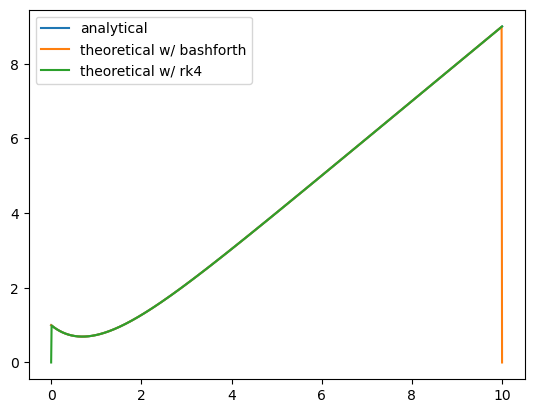

In [40]:
def eq(x, t):
    """
    test diff eq for adams bashforth
    """
    return t - x

def soln(x, t):
    """
    known solution for test diff eq above with initial value = 1
    """
    return 2 * np.exp(-t) + t - 1

soln_x = np.zeros(1000 + 1)
soln_t = t_vals = np.linspace(0, 1000 * .01, 1000 + 1)

analytical = soln(soln_x, soln_t)

t, theoretical_bash = adams_bashforth(eq, 1, .01, 1000)
t, theoretical_rk4 = rk4(eq, 1, .01, 1000)

plt.plot(soln_t, analytical, label = "analytical")
plt.plot(t, theoretical_bash, label = "theoretical w/ bashforth")
plt.plot(t, theoretical_rk4, label = "theoretical w/ rk4")
plt.legend()

### Animated Simulation

In [42]:
def animate_pendulum(r, theta, xlim, ylim, trace = "on"):
    """
    Animate the position of a pendulum over time using polar coordinates.
    
    r : List or array of radial (distance) values.
    theta : List or array of angular (theta) values.

    output : animated graph of the spring over time
    """
    def pend_pos(r, theta):
        return (r * np.sin(theta), -r * np.cos(theta))

    fig = plt.figure()
    ax = fig.add_subplot(aspect = 'equal')
    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-ylim, ylim)
    ax.grid
    x0, y0 = pend_pos(r[0], theta[0])
    line, = ax.plot([0, x0], [0, y0], lw=2, c='k')
    circle = ax.add_patch(plt.Circle(pend_pos(r[0], theta[0]), 0.05, fc='r', zorder=3))

    # objects that trace the path of the mass
    if trace == "on":
        trace, = ax.plot([], [], 'b-', alpha=0.5, lw=1)
        trace_x, trace_y = [], []  # Lists to store the path coordinates
    def animate(i):
        x, y = pend_pos(r[i], theta[i])
        line.set_data([0, x], [0, y])
        circle.set_center((x, y))
        if trace == "on":
            trace_x.append(x)
            trace_y.append(y)
            # Update trace line
            trace.set_data(trace_x, trace_y)

        

    ani = animation.FuncAnimation(fig, animate, frames = len(r))
    return HTML(ani.to_jshtml())

In [44]:
def trace_location(r, theta):
    """
    function that outputs the traced position of the mass. Note that the red dot is the starting
    location and the blue dot is the ending locaiton
    """
    def pend_pos(r, theta):
        return (r * np.sin(theta), -r * np.cos(theta))
    x_pos = np.zeros(len(theta))
    y_pos = np.zeros(len(theta))
    for i in range(len(theta)):
        x_pos[i], y_pos[i] = pend_pos(r[i], theta[i])
    plt.plot(x_pos, y_pos, label = "position")
    plt.xlabel("x posiiton")
    plt.ylabel("y position")
    plt.scatter(x_pos[1], y_pos[1], s = 100, color = "red", label = "starting position") # using second element for rk4's sake
    plt.scatter(x_pos[-2], y_pos[-2], s = 100, color = "blue", label = "ending position") # using second to last element for bash's sake
    plt.scatter(0, 0, marker = "^", s = 50, color = "black", label = "pendulum attached here")
    plt.legend()
    plt.show()

### Special Cases (with known solutions)

Firstly, in terms of special cases, it might be easier to think about the special cases where there is no driving or damping.

1. 
Of the no damping or driving cases, when $r = 1$ (spring is at equilibrium), and everything else = 0 (no initial radial or angular velocity and spring is hanging vertically), we know that the only factor causing any variation in the data should be $\gamma$. When $\gamma$ is larger, we should expect more oscillations in the length of the spring with a greater amplitude where the spring oscillates back and forth from equilibrium.

$$0 = \theta, v_o, \Theta_o$$
$$1 = \hat{r_o}$$

This case serves as a good point to analyze the role the $\gamma$ plays in the motion of the elastic pendulum. In this case, we can see how the gravity affects the length of the spring.

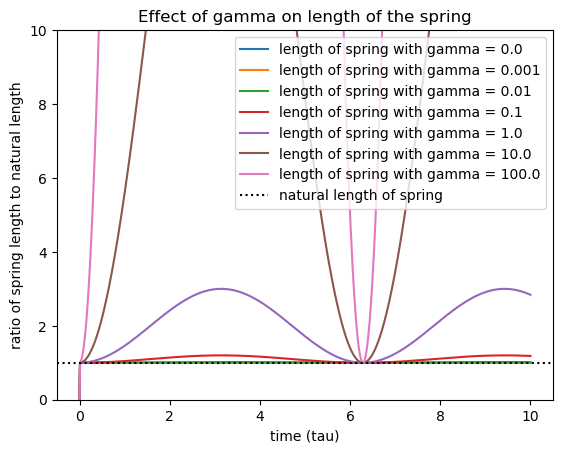

In [46]:
initial_conditions = np.array([1, 0, 0, 0])
step_count = 1000
step_size = .01
tau_vals = np.linspace(0, step_size * step_count, step_count + 1)

gamma_vals = np.array([0, .001, .01, .1, 1, 10, 100])
theta_vals = np.zeros((len(gamma_vals), step_count + 1))
r_vals = np.zeros((len(gamma_vals), step_count + 1))

for i in range(len(gamma_vals)):
    r_vals[i], theta_vals[i], r_dot, theta_dot = elastic_pendulum_rk4(initial_conditions, step_size, step_count, gamma_vals[i], 0, 0, 0, 0, 0, 0)

for i in range(len(gamma_vals)):
    plt.plot(tau_vals, r_vals[i], label = f"length of spring with gamma = {gamma_vals[i]}")

plt.ylim(0, 10)
plt.title("Effect of gamma on length of the spring")
plt.xlabel("time (tau)")
plt.ylabel("ratio of spring length to natural length")
plt.axhline(y=1, linestyle=':', color='black', label = "natural length of spring")
plt.legend()

As is apparent in the graph above and as we expect, we can see that when the gamma constant is larger, the string becomes much more outstretched before returning to equilibrium. From this figure we can also think about what we might want to use for the rest of the project. In this case, if we are thinking about a realistic system, I think that a gamma value of .005 would most accurately model a real world situation.

Another important case to consider is the case where there is no damping or driving forces, the spring is at its natural length, and the spring starts at ($\frac{\pi}{4}$) away from the vertical. Next we can assume no initial velocity, to let the spring move naturally to equilibrium.

$$0 = v_o, \Theta_o$$
$$1 = \hat{r_o}$$
$$\frac{\pi}{4} = \theta$$

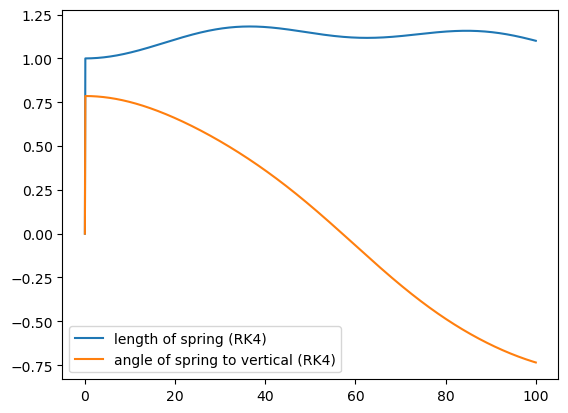

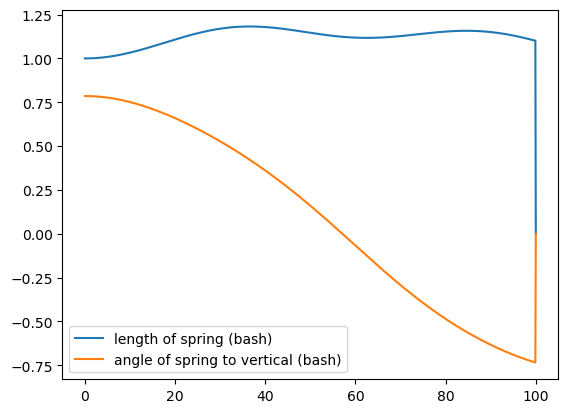

In [49]:
step_count = 1000
step_size = .1
tau_vals = np.linspace(0, step_size * step_count, step_count + 1)
initial_conditions = np.array([1, np.pi / 4, 0, 0])

r, theta, r_dot, theta_dot = elastic_pendulum_rk4(initial_conditions, .01, step_count, step_size, 0, 0, 0, 0, 0, 0)
r1, theta1, r_dot1, theta_dot1 = elastic_pendulum_bash(initial_conditions, .01, step_count, step_size, 0, 0, 0, 0, 0, 0)

plt.plot(tau_vals, r, label = "length of spring (RK4)")
plt.plot(tau_vals, theta, label = "angle of spring to vertical (RK4)")
# plt.plot(tau_vals, theta, label = "angle spring forms with vertical")
plt.legend()
plt.show()

plt.plot(tau_vals, r1, label = "length of spring (bash)")
plt.plot(tau_vals, theta1, label = "angle of spring to vertical (bash)")
plt.legend()
plt.show()

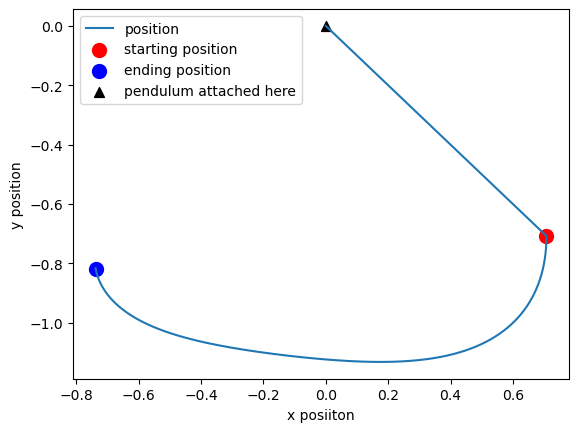

In [287]:
trace_location(r, theta)

### Time Grid and Gamma

Another interesting note here is that we can also observe the effect of the time constraints (step_count and timecount). It may not seem important however to understand the effects that the time has on our system we must understand that the gamma constant is related to the time scale $\sqrt{\frac{m}{k}}$ that we are using. More specifically: $\gamma = \frac{gm}{kl} = T^2 \frac{g}{l}$. To do this we will make 3 plots, using the same initial conditions as above. One plot will have $\gamma = .01$, $\Delta \tau = .01$, and $steps = 100, 1000, 10000$. The next plot will have $\gamma = .01$, $\Delta \tau = .001, .01, .1, 1$, and $steps = 1000$. And lastly, the last plot will have $\gamma = .001, .01, .1, 1$, $\Delta \tau = .01$, and $steps = 1000$.

The goal of the is to observe some sort of inverse relationship between the time grid and the value of $\gamma$.

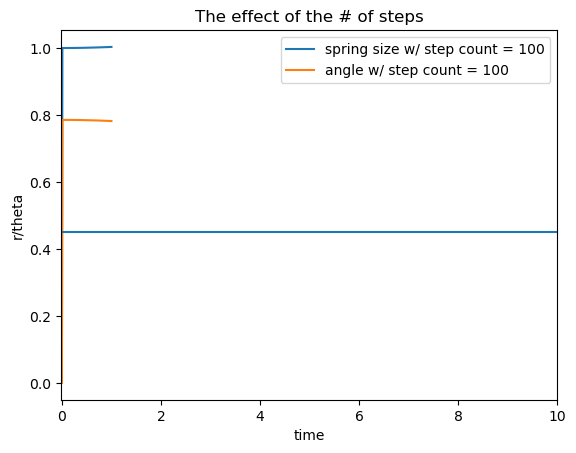

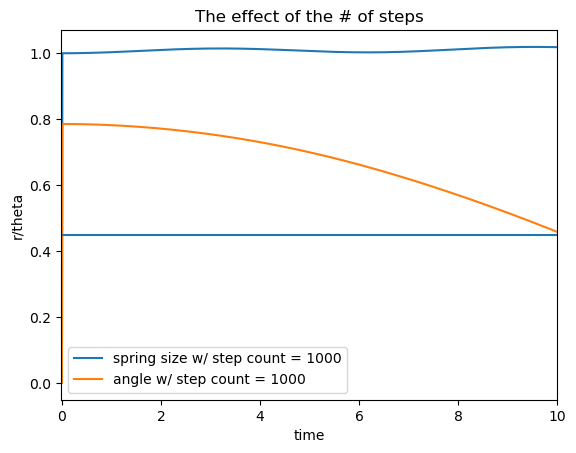

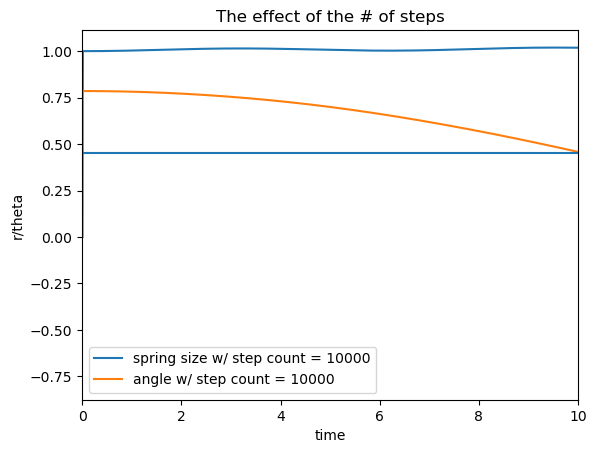

In [55]:
step_count = np.array([100, 1000, 10000])
step_size = .01
gamma = .01
initial_conditions = np.array([1, np.pi / 4, 0, 0])

for steps in step_count:
    tau_vals = np.linspace(0, step_size * steps, steps + 1)
    r, theta, r_dot, theta_dot = elastic_pendulum_rk4(initial_conditions, gamma, steps, step_size, 0, 0, 0, 0, 0, 0)

    plt.plot(tau_vals, r, label = f"spring size w/ step count = {steps}")
    plt.plot(tau_vals, theta, label = f"angle w/ step count = {steps}")
    plt.legend()
    plt.xlim(-.01, 10)
    plt.axhline(.45)
    plt.xlabel("time")
    plt.ylabel("r/theta")
    plt.title("The effect of the # of steps")
    plt.show()

In these figures, we can see that roughly speaking, when we show the graphs from $\tau = 0$ to $\tau = 1$ we see the same thing in both graphs. This is reassuring because it tells us that the number of steps doesnt effect the role of gamma. Next when comparing the graphs from $\tau = 0$ to $\tau = 10$, we see the same lack of difference in the two graphs (this is shown explicitly with the horizontal line).


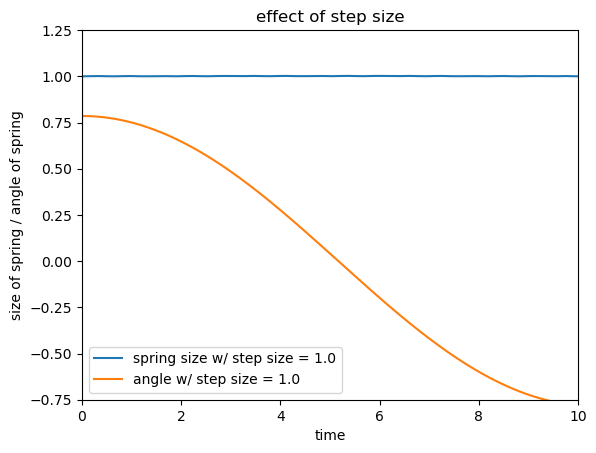

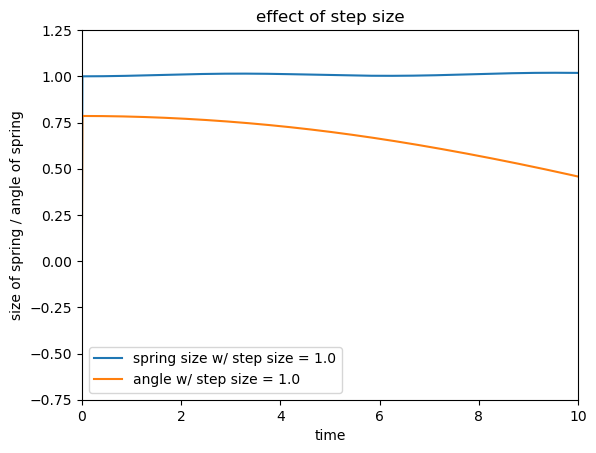

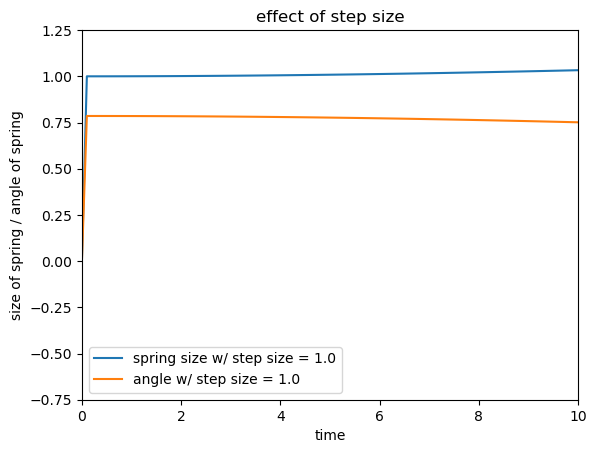

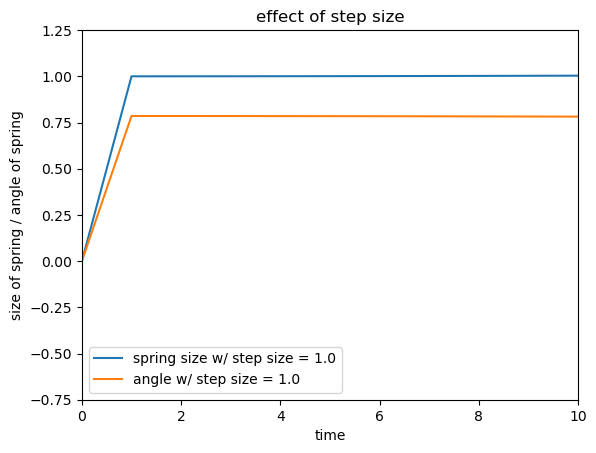

In [65]:
# changing step size

step_count = np.array([10000, 1000, 100, 10])
step_size = np.array([.001, .01, .1, 1])
gamma = .01
initial_conditions = np.array([1, np.pi / 4, 0, 0])

for i in range(len(step_size)):
    tau_vals = np.linspace(0, step_size[i] * step_count[i], step_count[i] + 1)
    r, theta, r_dot, theta_dot = elastic_pendulum_rk4(initial_conditions, gamma, step_count[i], step_size[i], 0, 0, 0, 0, 0, 0)

    plt.plot(tau_vals, r, label = f"spring size w/ step size = {size}")
    plt.plot(tau_vals, theta, label = f"angle w/ step size = {size}")
    plt.legend()
    plt.xlim(0, 10)
    plt.ylim(-.75, 1.25)
    plt.xlabel("time")
    plt.ylabel("size of spring / angle of spring")
    plt.title("effect of step size")
    plt.show()

In this figure, we see some results that are a bit more interesting. basically, what we can gather from these graphs is the relevance of step_size and step_count comes from the step density. Specifically, step density refers to the number of steps per unit time, the greater this is the more accurate the data plot will be. This leads me back to the error in the assumption made at the start of this section, that is, that gamma and t are related (they are not).

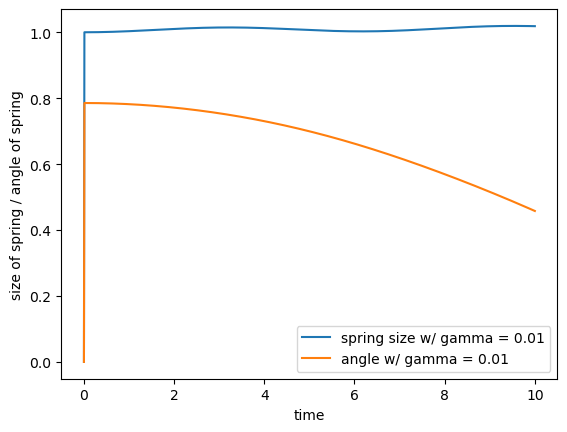

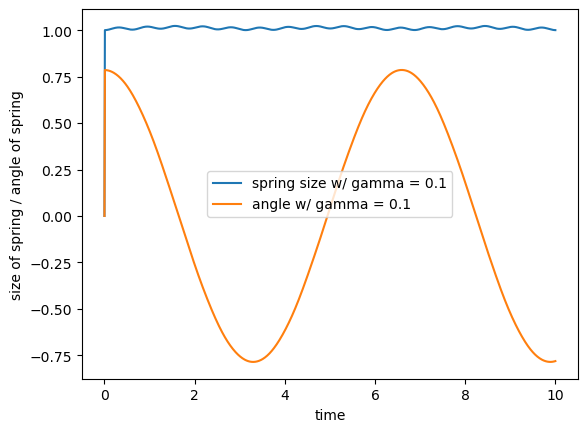

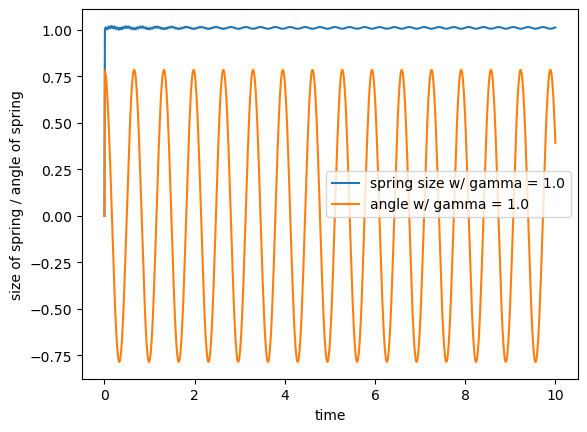

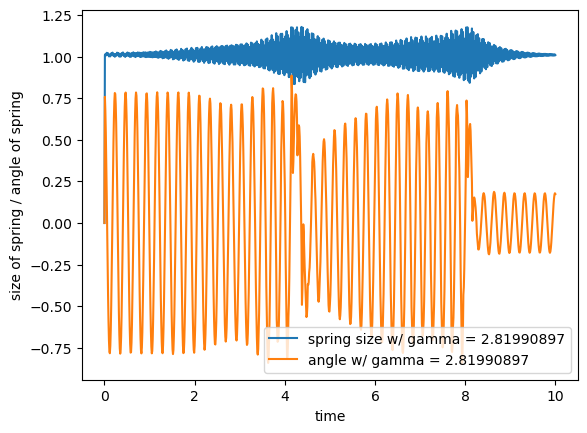

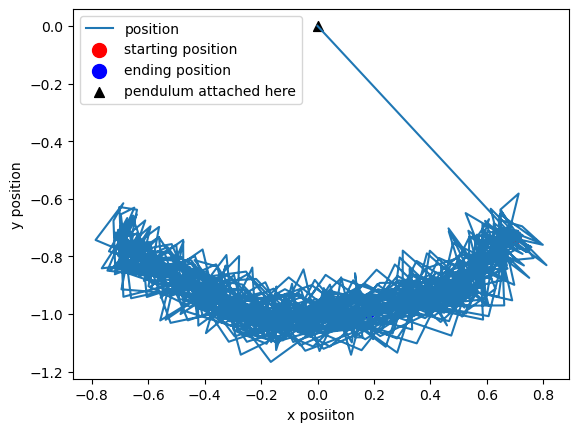

In [343]:
# changing gamma

step_count = 1000
step_size = .01
gamma_vals = np.array([.01, .1, 1, 2.81990897])
initial_conditions = np.array([1, np.pi / 4, 0, 0])

for gamma in gamma_vals:
    tau_vals = np.linspace(0, step_size * step_count, step_count + 1)
    r, theta, r_dot, theta_dot = elastic_pendulum_rk4(initial_conditions, gamma, step_count, step_size, 0, 0, 0, 0, 0, 0)

    plt.plot(tau_vals, r, label = f"spring size w/ gamma = {gamma}")
    plt.plot(tau_vals, theta, label = f"angle w/ gamma = {gamma}")
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("size of spring / angle of spring")
    plt.show()

trace_location(r, theta)

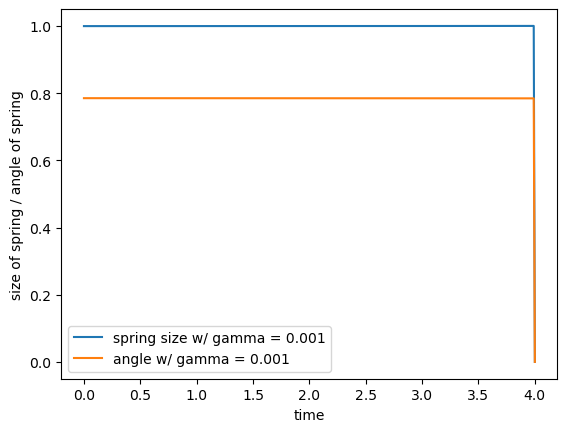

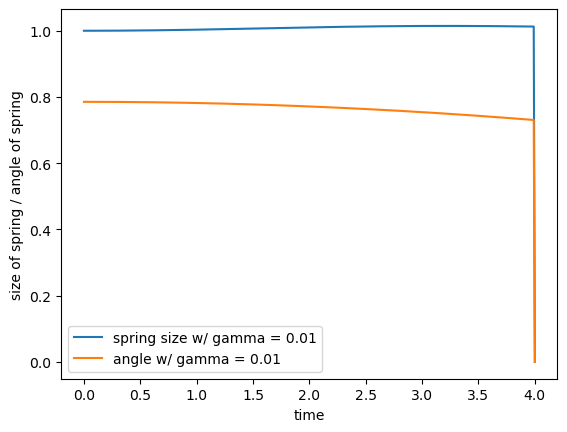

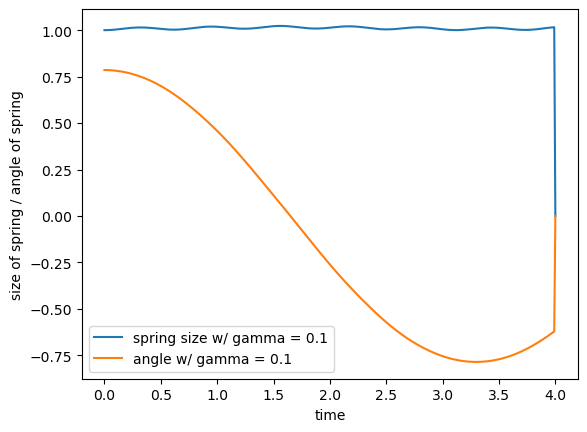

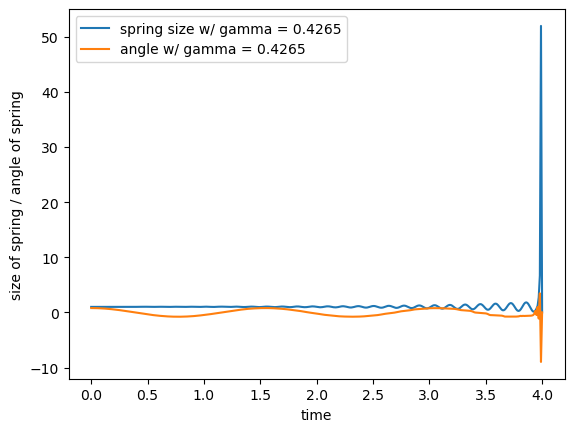

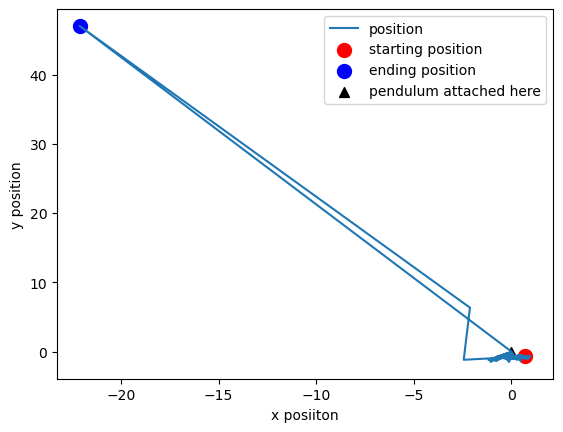

In [357]:
step_count = 400
step_size = .01
gamma_vals = np.array([.001, .01, .1, .4265])
initial_conditions = np.array([1, np.pi / 4, 0, 0])

for gamma in gamma_vals:
    tau_vals = np.linspace(0, step_size * step_count, step_count + 1)
    r, theta, r_dot, theta_dot = elastic_pendulum_bash(initial_conditions, gamma, step_count, step_size, 0, 0, 0, 0, 0, 0)

    plt.plot(tau_vals, r, label = f"spring size w/ gamma = {gamma}")
    plt.plot(tau_vals, theta, label = f"angle w/ gamma = {gamma}")
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("size of spring / angle of spring")
    plt.show()

trace_location(r, theta)

In these results we can clearly see that as expected, when gamma increases, the frequency of the oscillations in angle and size of the spring increases. However, it is important to notice (apparent in the two greatest gamma value plots) that the amplitude of the of the oscillations actually doesnt change significantly. 

Lastly, the most interesting phenomena we can observe here is the critical value we have found for gamma. As of now, I am unsure why exactly this value is critical, however at just above 2.81990625 gamma begins the influence the graph peculiarly, increasing the "oscillations" of both length and angle of the spring to unrealistically high values. It is also important ot notice that there is an element of either chaos or bifurcation at gamma approaches this value which we will explore later.

Another important thing to notice about the two previous boxes, is that we can see that the bashforth method seems to handle the results more realistically. That is, once gamme reaches a certain value, there is no chaos but rather the final angle and radial position of the spring increases exponentially, as gamma increases, which is what is expected.

As an experiment, lets see what happens when we plot final angle of the spring as a function of gamma

/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_9812/4189786173.py:57: RuntimeWarning: overflow encountered in scalar power
  radial_acceleration = ((x[0]) * (x[3]**2)) + (1 - x[0]) + (gamma * np.cos(x[1])) - (C_2 * x[1]) + (F_2 * np.cos(omega_r * t))
/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_9812/4189786173.py:58: RuntimeWarning: overflow encountered in scalar multiply
  angular_acceleration = ((-gamma/x[0]) * np.sin(x[1])) - (2 * x[3] * x[2] / x[0]) - (C_1 * x[3]) + (F_1 * np.cos(omega_theta * t))
/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_9812/4189786173.py:58: RuntimeWarning: invalid value encountered in scalar multiply
  angular_acceleration = ((-gamma/x[0]) * np.sin(x[1])) - (2 * x[3] * x[2] / x[0]) - (C_1 * x[3]) + (F_1 * np.cos(omega_theta * t))
/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_9812/4189786173.py:57: RuntimeWarning: invalid value encountered in cos
  radial_acceleration = ((x[0]) * (x[3]**2)) + (1 - x[0]) + (

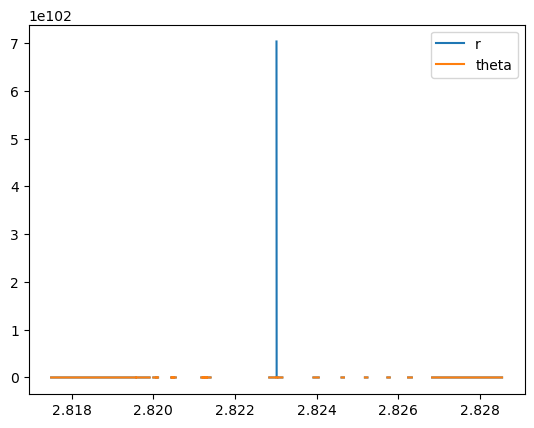

In [80]:
N = 10000
gamma_vals = np.linspace(2.8175, 2.83, N)

step_size = .01
step_count = 500 
initial_conditions = np.array([1, np.pi / 4, 0, 0])
r_vals = np.zeros(N)
theta_vals = np.zeros(N)

for i in range(N):
    tau_vals = np.linspace(0, step_size * step_count, step_count + 1)
    r, theta, r_dot, theta_dot = elastic_pendulum_rk4(initial_conditions, gamma_vals[i], step_count, step_size, 0, 0, 0, 0, 0, 0)
    theta_vals[i] = theta[-1]
    r_vals[i] = r[-1]

plt.plot(gamma_vals, r_vals, label = "r")
plt.plot(gamma_vals, theta_vals, label = "theta")
plt.legend()

This is interesting, as there is apparent chaos occurring. What we can notice through testing is that as we raise the density of the time grid, we get a more well defined chaotic plot.

### The Effects of $v_o$ and $\Theta_o$

In this portion of the notebook, I aim to find the effect that $v_o$ and $\Theta_o$ have on the motion of the elastic pendulum. Specifically, I aim to find ranges in which certain phenomena can be observed (eventually chaos). 

To start lets observe the effects of $\Theta_o$ with values 1, 10, 100

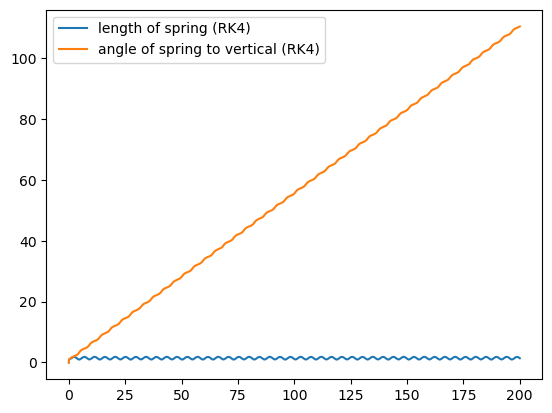

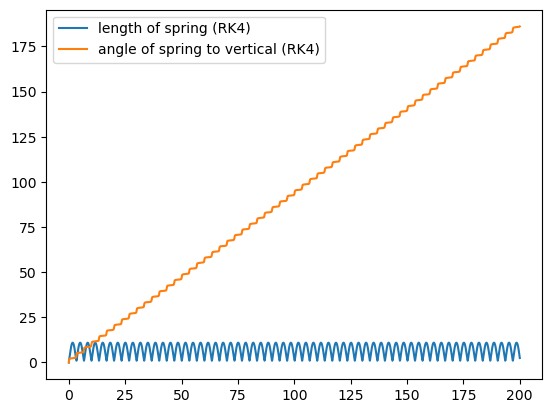

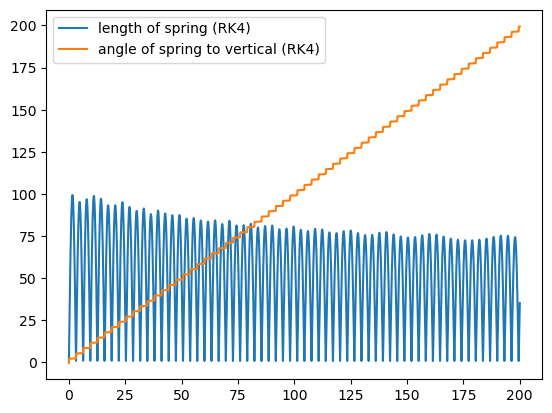

In [46]:
step_count = 20000
step_size = .01
tau_vals = np.linspace(0, step_size * step_count, step_count + 1)
Theta_o = np.array([1, 10, 100])

for val in Theta_o:
    initial_conditions = np.array([1, np.pi/4, 0, val])

    r, theta, r_dot, theta_dot = elastic_pendulum_rk4(initial_conditions, .01, step_count, step_size, 0, 0, 0, 0, 0, 0)
    
    plt.plot(tau_vals, r, label = "length of spring (RK4)")
    plt.plot(tau_vals, theta, label = "angle of spring to vertical (RK4)")
    
    # plt.plot(tau_vals, theta, label = "angle spring forms with vertical")
    plt.legend()
    plt.show()

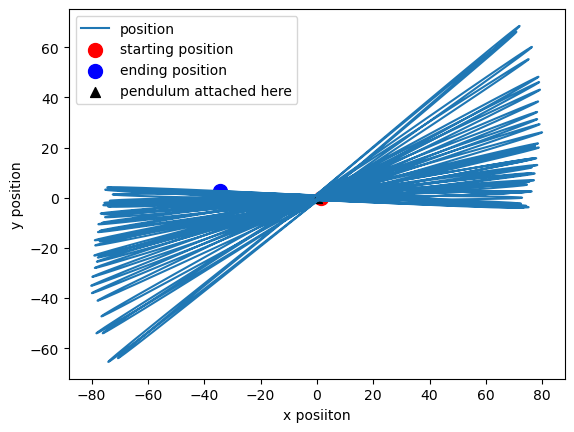

In [47]:
trace_location(r, theta)

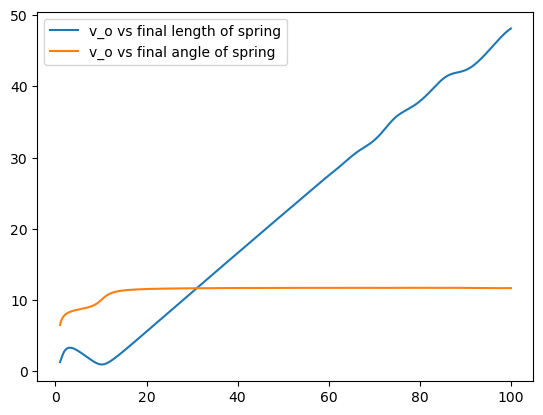

In [48]:
step_count = 1000
step_size = .01
N = 1000
tau_vals = np.linspace(0, step_size * step_count, step_count + 1)
Theta_o = np.linspace(1, 100, 1000)
theta_final = np.zeros([N])
r_final = np.zeros([N])

for i in range(N):
    initial_conditions = np.array([1, np.pi/4, 0, Theta_o[i]])

    r, theta = elastic_pendulum_rk4(initial_conditions, .01, step_count, step_size)

    r_final[i] = r[-1]
    theta_final[i] = theta[-1]

plt.plot(Theta_o, r_final, label = "v_o vs final length of spring")
plt.plot(Theta_o, theta_final, label = "v_o vs final angle of spring")
plt.legend()
plt.show()

what we can see from these figures is that, as there is more initial energy added into the system, more choatic phenomena occur. For example, this can be seen when looking at the magnitude of the oscillations of the length of the spring. when looking at these magnitudes we can see that they appear to translate some of the radial velocity into angular velocity causing the increase in angle to be increasingly out of phase with the spring length oscillations.

### Now we can do the same with radial velocity for values 1, 10, 100

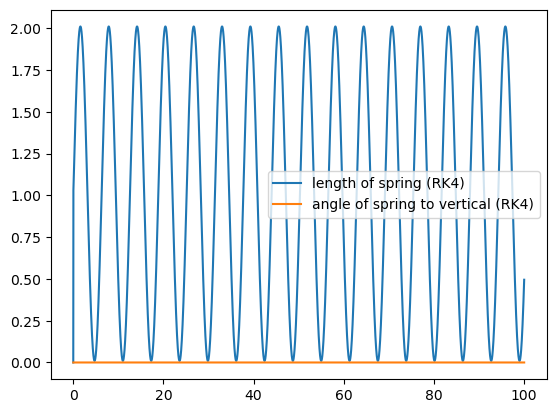

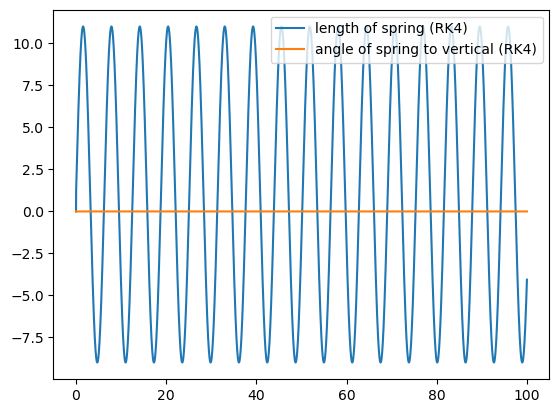

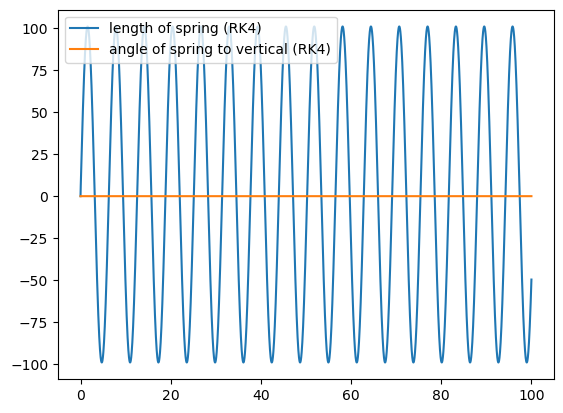

In [50]:
step_count = 10000
step_size = .01
tau_vals = np.linspace(0, step_size * step_count, step_count + 1)
v_o = np.array([1, 10, 100])
for val in v_o:
    initial_conditions = np.array([1, 0, val, 0])

    r, theta = elastic_pendulum_rk4(initial_conditions, .01, step_count, step_size)

    plt.plot(tau_vals, r, label = "length of spring (RK4)")
    plt.plot(tau_vals, theta, label = "angle of spring to vertical (RK4)")
    # plt.plot(tau_vals, theta, label = "angle spring forms with vertical")
    plt.legend()
    plt.show()

As we can see from the graphs of radial velocity, it makes sense for us to spice things up a bit by starting the spring at some intitial angle or with some angular velocity.

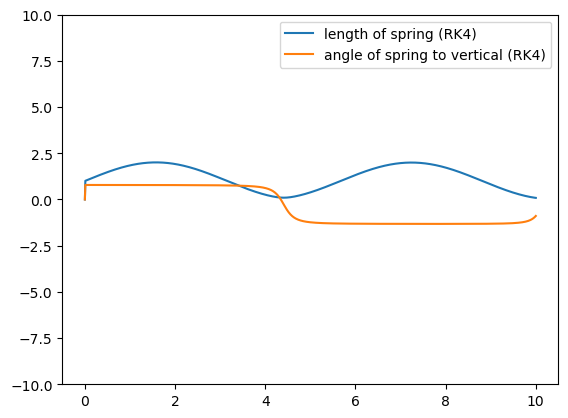

/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_63520/1471599921.py:57: RuntimeWarning: overflow encountered in scalar multiply
  radial_acceleration = ((x[0]) * (x[3]**2)) + (1 - x[0]) + (gamma * np.cos(x[1])) #  - (C_2 * x[1]) + (F_2 * np.cos(omega_r * t))
/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_63520/1471599921.py:57: RuntimeWarning: invalid value encountered in scalar add
  radial_acceleration = ((x[0]) * (x[3]**2)) + (1 - x[0]) + (gamma * np.cos(x[1])) #  - (C_2 * x[1]) + (F_2 * np.cos(omega_r * t))
/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_63520/1471599921.py:58: RuntimeWarning: invalid value encountered in scalar divide
  angular_acceleration = ((-gamma/x[0]) * np.sin(x[1])) - (2 * x[3] * x[2] / x[0]) #  - (C_1 * x[3]) + (F_2 * np.cos(omega_theta * t))
/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_63520/1471599921.py:57: RuntimeWarning: invalid value encountered in cos
  radial_acceleration = ((x[0]) * (x[3]**2)) + (1 -

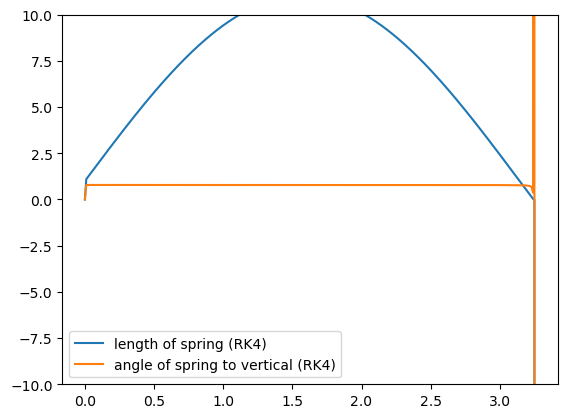

/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_63520/1471599921.py:58: RuntimeWarning: overflow encountered in scalar multiply
  angular_acceleration = ((-gamma/x[0]) * np.sin(x[1])) - (2 * x[3] * x[2] / x[0]) #  - (C_1 * x[3]) + (F_2 * np.cos(omega_theta * t))
/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_63520/1471599921.py:21: RuntimeWarning: invalid value encountered in add
  k_2 = function(x_n + (k_1/2), t_n + (step_size/2)) * step_size
/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_63520/1471599921.py:24: RuntimeWarning: invalid value encountered in add
  x_n = x_n + (k_1/6) + (k_2/3) + (k_3/3) + (k_4/6)


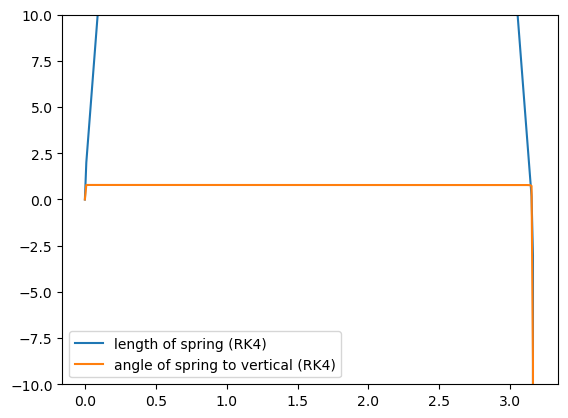

In [52]:
step_count = 1000
step_size = .01
tau_vals = np.linspace(0, step_size * step_count, step_count + 1)
v_o = np.array([1, 10, 100])
for val in v_o:
    initial_conditions = np.array([1, np.pi/4, val, 0])

    r, theta = elastic_pendulum_rk4(initial_conditions, .01, step_count, step_size)

    plt.plot(tau_vals, r, label = "length of spring (RK4)")
    plt.plot(tau_vals, theta, label = "angle of spring to vertical (RK4)")
    # plt.plot(tau_vals, theta, label = "angle spring forms with vertical")
    plt.ylim(-10, 10)
    plt.legend()
    plt.show()

In [53]:
# animate_pendulum(r, theta, 10, 10)

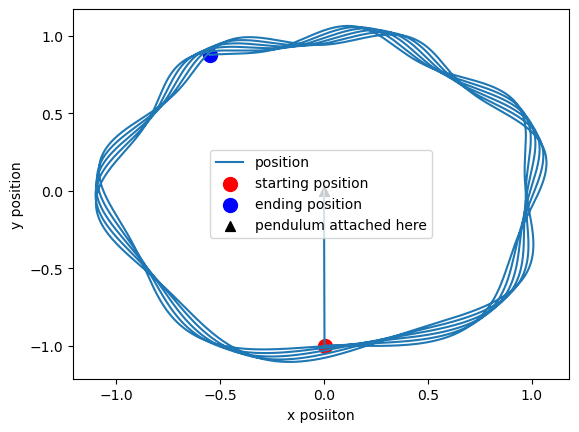

In [54]:
initial_conditions = np.array([1, 0, 0, .25])
step_count = 20000
step_size = .01

r, theta = elastic_pendulum_rk4(initial_conditions, .01, step_count, step_size)

trace_location(r, theta)

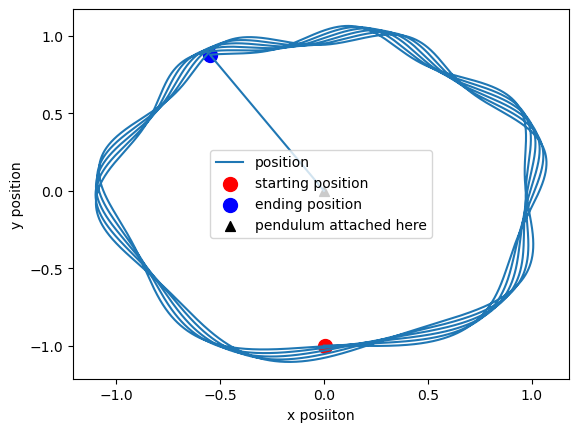

In [55]:
initial_conditions = np.array([1, 0, 0, .25])
step_count = 20000
step_size = .01

r, theta, r_dot, theta_dot = elastic_pendulum_bash(initial_conditions, .01, step_count, step_size, 0, 0, 0, 0, 0, 0)

trace_location(r, theta)

/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_9812/4189786173.py:57: RuntimeWarning: overflow encountered in scalar multiply
  radial_acceleration = ((x[0]) * (x[3]**2)) + (1 - x[0]) + (gamma * np.cos(x[1])) - (C_2 * x[1]) + (F_2 * np.cos(omega_r * t))
/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_9812/4189786173.py:58: RuntimeWarning: overflow encountered in scalar multiply
  angular_acceleration = ((-gamma/x[0]) * np.sin(x[1])) - (2 * x[3] * x[2] / x[0]) - (C_1 * x[3]) + (F_1 * np.cos(omega_theta * t))
/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_9812/4189786173.py:58: RuntimeWarning: invalid value encountered in scalar multiply
  angular_acceleration = ((-gamma/x[0]) * np.sin(x[1])) - (2 * x[3] * x[2] / x[0]) - (C_1 * x[3]) + (F_1 * np.cos(omega_theta * t))
/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_9812/4189786173.py:57: RuntimeWarning: invalid value encountered in cos
  radial_acceleration = ((x[0]) * (x[3]**2)) + (1 - x[0]) 

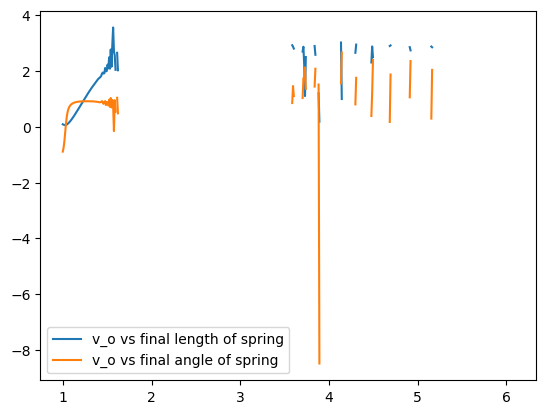

In [85]:
step_count = 1000
step_size = .01
N = 1000
tau_vals = np.linspace(0, step_size * step_count, step_count + 1)
v_o = np.linspace(1, 10, step_count)
r_final = np.zeros(N)
theta_final = np.zeros(N)

for i in range(N):
    initial_conditions = np.array([1, np.pi/4, v_o[i], 0])

    r, theta, r_dot, theta_dot = elastic_pendulum_rk4(initial_conditions, .01, step_count, step_size, 0, 0, 0, 0, 0, 0)
    r_final[i] = r[-1]
    theta_final[i] = theta[-1]

plt.plot(v_o, r_final, label = "v_o vs final length of spring")
plt.plot(v_o, theta_final, label = "v_o vs final angle of spring")
plt.legend()
plt.show()

/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_9812/3503215092.py:28: RuntimeWarning: overflow encountered in scalar power
  radial_acceleration = ((x[0]) * (x[3]**2)) + (1 - x[0]) + (gamma * np.cos(x[1])) - (C_2 * x[1]) + (F_2 * np.cos(omega_r * t))
/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_9812/3503215092.py:29: RuntimeWarning: overflow encountered in scalar multiply
  angular_acceleration = ((-gamma/x[0]) * np.sin(x[1])) - (2 * x[3] * x[2] / x[0]) - (C_1 * x[3]) + (F_1 * np.cos(omega_theta * t))
/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_9812/3503215092.py:29: RuntimeWarning: invalid value encountered in scalar multiply
  angular_acceleration = ((-gamma/x[0]) * np.sin(x[1])) - (2 * x[3] * x[2] / x[0]) - (C_1 * x[3]) + (F_1 * np.cos(omega_theta * t))
/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_9812/3886108253.py:31: RuntimeWarning: invalid value encountered in subtract
  f_vals[i+1] = f_vals[i] + ((step_size / 2.0) * ((3 * f

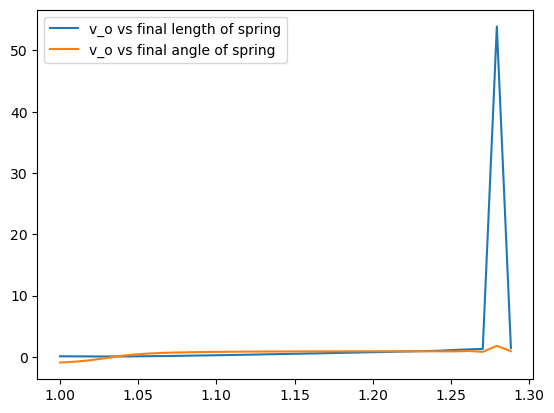

In [86]:
step_count = 1000
step_size = .01
N = 1000
tau_vals = np.linspace(0, step_size * step_count, step_count + 1)
v_o = np.linspace(1, 10, step_count)
r_final = np.zeros(N)
theta_final = np.zeros(N)

for i in range(N):
    initial_conditions = np.array([1, np.pi/4, v_o[i], 0])

    r, theta, r_dot, theta_dot = elastic_pendulum_bash(initial_conditions, .01, step_count, step_size, 0, 0, 0, 0, 0, 0)
    r_final[i] = r[-2]
    theta_final[i] = theta[-2]

plt.plot(v_o, r_final, label = "v_o vs final length of spring")
plt.plot(v_o, theta_final, label = "v_o vs final angle of spring")
plt.legend()
plt.show()

here we can see some of the differences between the two numerical methods that we used. Here it is apparent that the RK4 method covers a wider range of initial velocity values, however with that comes more discontinuities in the graph. What I prefer about the Linear multistep method here is that it is continuous across the range of initial velocities that it shows. We can also note that as we increase the density of the time grid, we will see less discontinuities in the RK4 plot and a wider range of data shown in the Linear multistep plot.

### Damping and Driving

Before thinking about chaos and bifurcation, lets analyze the effect of damping and driving on a few of the cases observed above. To analyze the damping and driving time evolution of the position of the mass we will use the adams bashforth function.

In terms of which cases we will observe, we will start with the spring being released at its natural length from position $\frac{\pi}{4}$

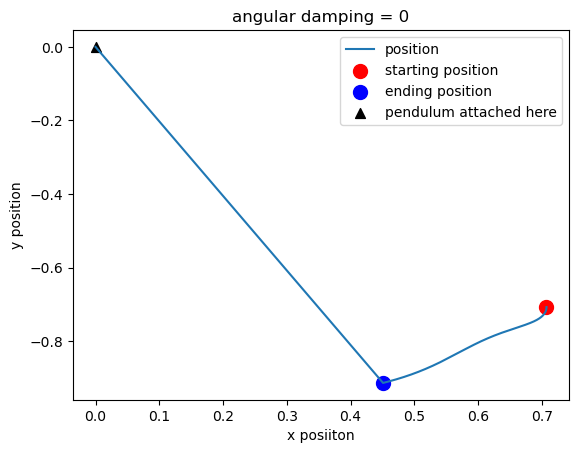

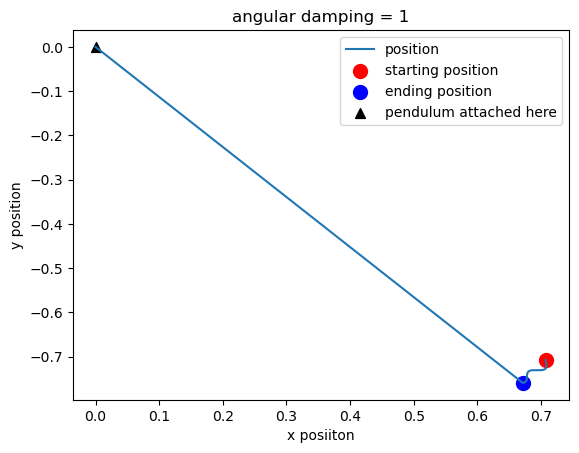

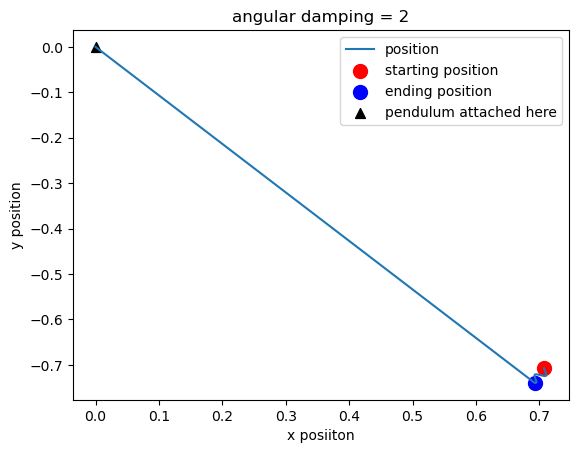

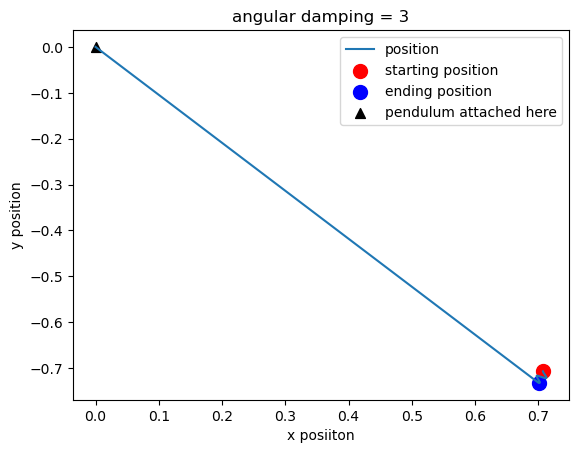

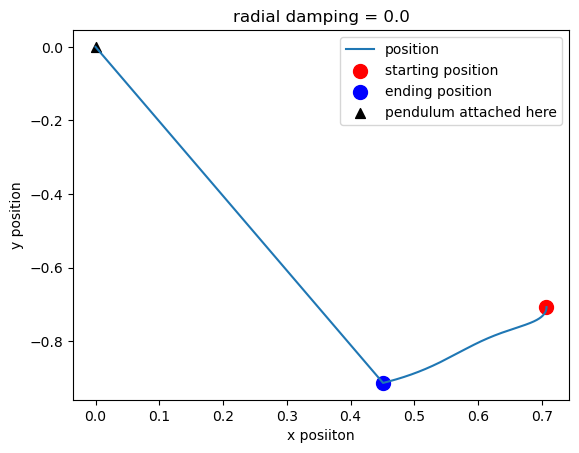

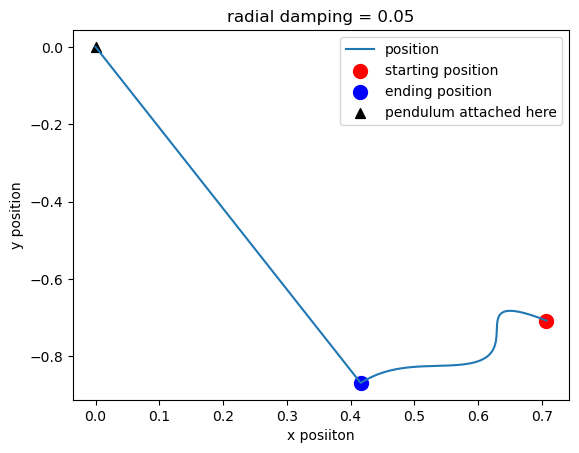

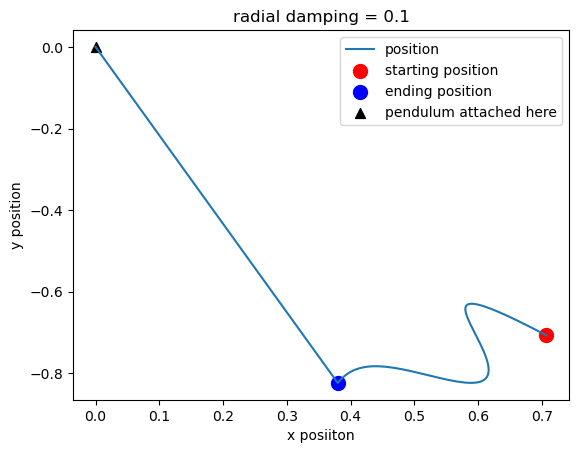

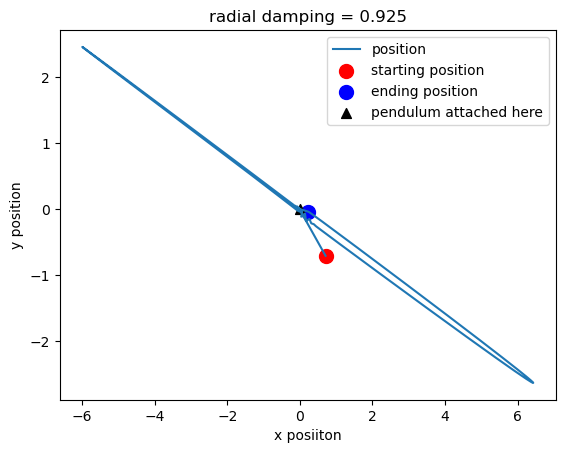

In [66]:
### damping force
# angular first, radial second
initial_conditions = np.array([1, np.pi/4, 0, 0])
step_count = 1000
step_size = .01
angular_damping = np.array([0, 1, 2, 3])
radial_damping = np.array([0, .05, .1, .925])

for damping in angular_damping:
    r, theta, r_dot, theta_dot = elastic_pendulum_bash(initial_conditions, .01, step_count, step_size, damping, 0, 0, 0, 0, 0)
    plt.title(f"angular damping = {damping}")
    trace_location(r, theta)
    

for damping in radial_damping:
    r, theta, r_dot, theta_dot = elastic_pendulum_bash(initial_conditions, .01, step_count, step_size, 0, damping, 0, 0, 0, 0)
    plt.title(f"radial damping = {damping}")
    trace_location(r, theta)

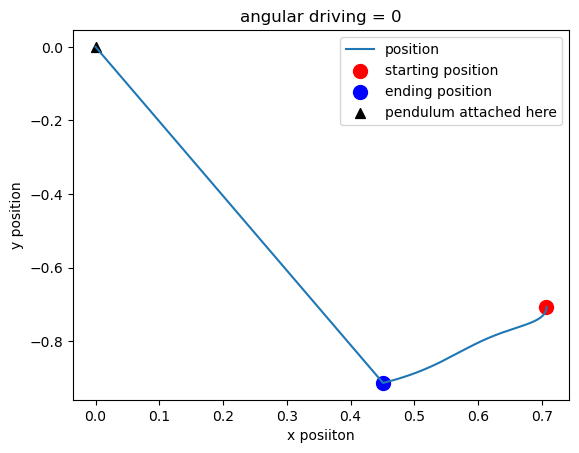

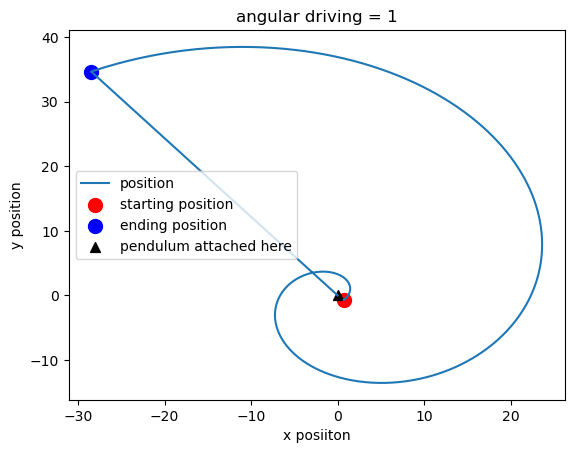

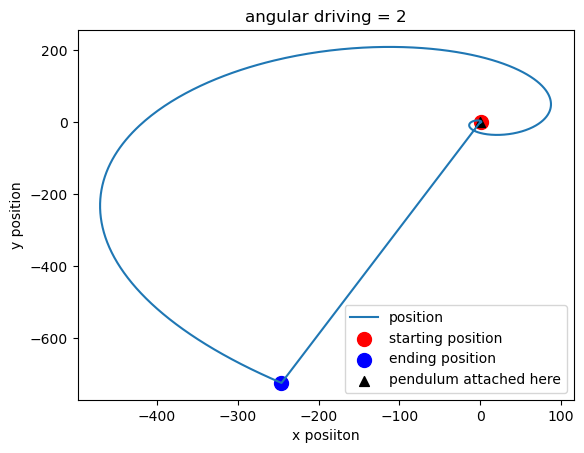

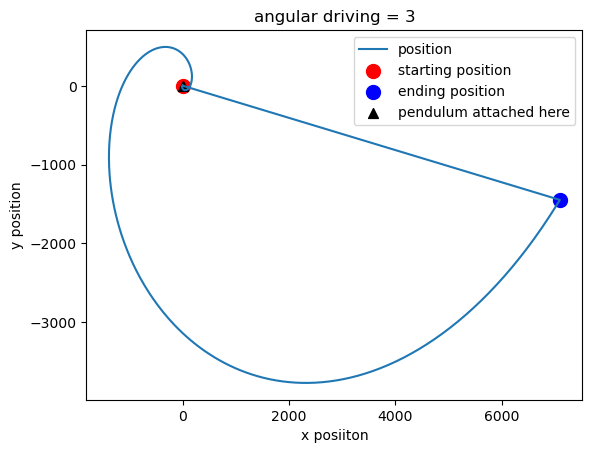

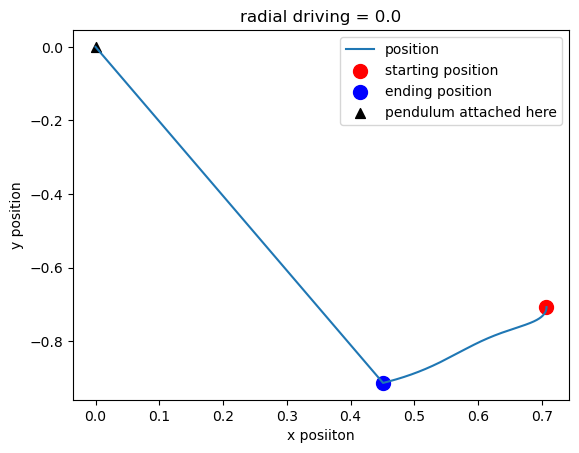

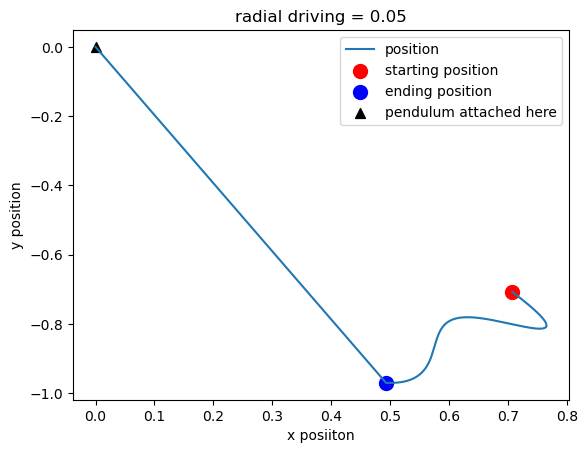

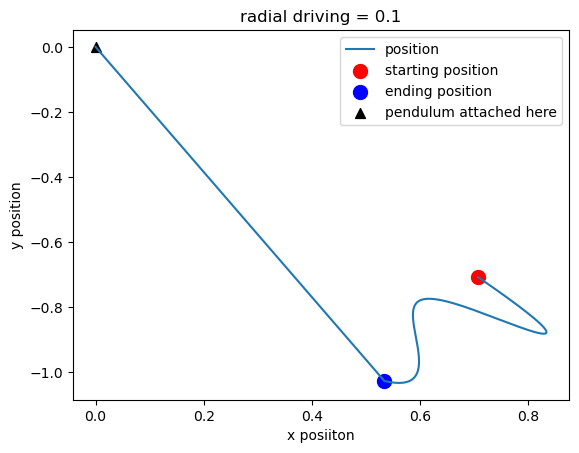

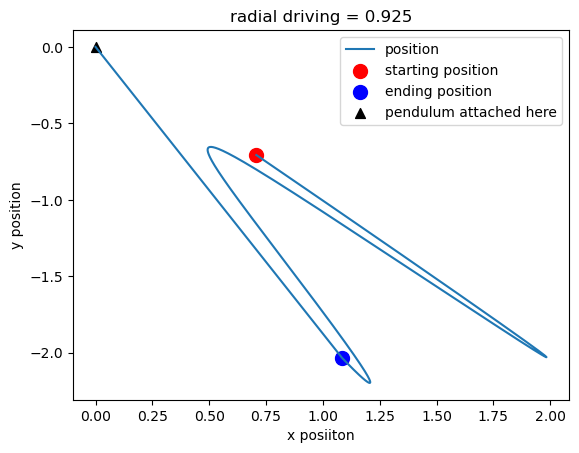

In [67]:
### driving force
initial_conditions = np.array([1, np.pi/4, 0, 0])
step_count = 1000
step_size = .01
F_angular = np.array([0, 1, 2, 3])
omega_angular = .1
F_radial = np.array([0, .05, .1, .925])
omega_radial = .1

for F in F_angular:
    r, theta, r_dot, theta_dot = elastic_pendulum_bash(initial_conditions, .01, step_count, step_size, 0, 0, F, 0, omega_angular, 0)
    plt.title(f"angular driving = {F}")
    trace_location(r, theta)

for F in F_radial:
    r, theta, r_dot, theta_dot = elastic_pendulum_bash(initial_conditions, .01, step_count, step_size, 0, 0, 0, F, 0, omega_radial)
    plt.title(f"radial driving = {F}")
    trace_location(r, theta)

The next cases we can observe are the cases above with initial velocity (angular, radial or both)


## Bifurcation Chaos and Patterns

Using the period of the driving force ($\omega_r, \omega_{\theta}$), first analyze one specific initial condition variable (we will start with $\Theta$) to see what ranges cause "new things to happen". Note that we can use the period of the driving force to sample the data too identify these "new" phenomena. Once we have the ranges first we can see what final values they approach (for $\theta$ and r) and then we can make a bifurcation diagram of $\Theta$ vs final r or $\theta$

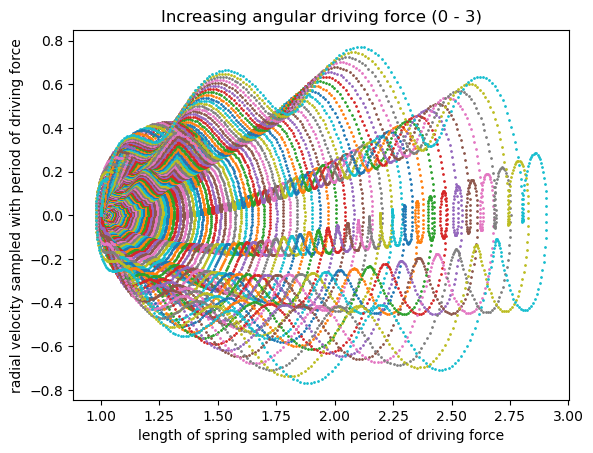

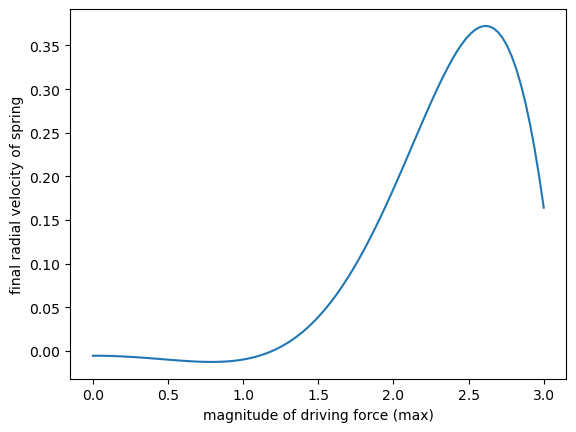

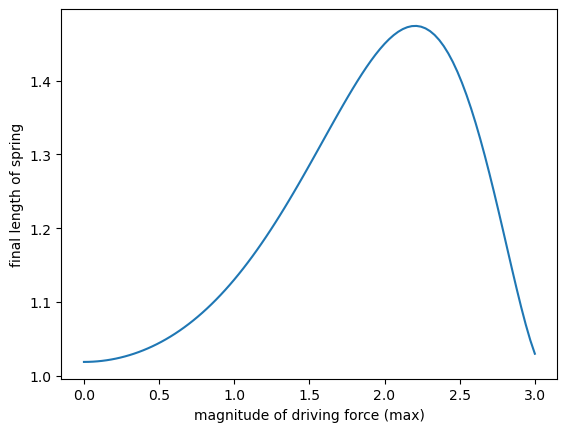

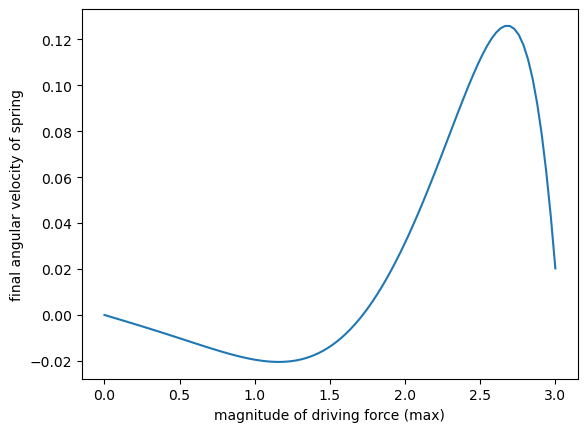

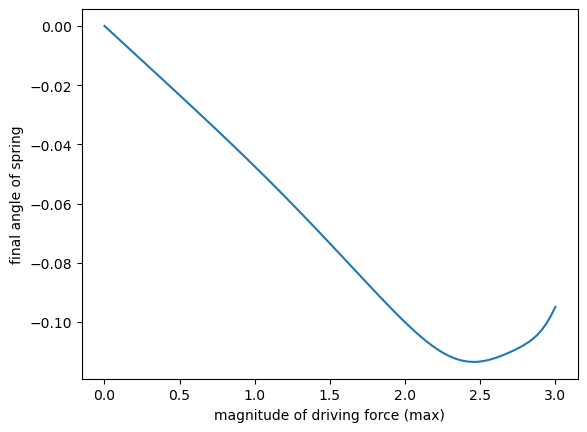

In [454]:
## testing sampling
initial_conditions = np.array([1, 0, 0, 0])
step_count = 1000
step_size = .01
t = np.linspace(0, step_count * step_size, step_count)

F_angular = np.linspace(0, 3, 100)
omega_angular = np.pi
sample_period = int(2 * np.pi / omega_angular) # best to make sure this is a round num

final_r = np.zeros(len(F_angular))
final_r_dot = np.zeros(len(F_angular))
final_theta = np.zeros(len(F_angular))
final_theta_dot = np.zeros(len(F_angular))

i = 0
for F in F_angular:
    r, theta, r_dot, theta_dot = elastic_pendulum_bash(initial_conditions, .01, step_count, step_size, 0, 0, F, 0, omega_angular, 0)

    sampled_r = r[::sample_period]
    sampled_r_dot = r_dot[::sample_period]
    
    plt.scatter(sampled_r[:-1], sampled_r_dot[:-1], s = 1)
    
    final_theta[i] = theta[-2] # using second to last because adams bashforth last val is position of pendulum
    final_theta_dot[i] = theta_dot[-2]
    final_r[i] = r[-2] # using second to last because adams bashforth last val is position of pendulum
    final_r_dot[i] = r_dot[-2]
    i += 1

plt.xlabel("length of spring sampled with period of driving force")
plt.ylabel("radial velocity sampled with period of driving force")
plt.title("Increasing angular driving force (0 - 3)")
plt.show()
plt.plot(F_angular, final_r_dot)
plt.xlabel("magnitude of driving force (max)")
plt.ylabel("final radial velocity of spring")
plt.show()
plt.plot(F_angular, final_r)
plt.xlabel("magnitude of driving force (max)")
plt.ylabel("final length of spring")
plt.show()
plt.show()
plt.plot(F_angular, final_theta_dot)
plt.xlabel("magnitude of driving force (max)")
plt.ylabel("final angular velocity of spring")
plt.show()
plt.plot(F_angular, final_theta)
plt.xlabel("magnitude of driving force (max)")
plt.ylabel("final angle of spring")
plt.show()

here we can see the effect of the angular driving force on the time evolution of the graph. What we can see in these figures is that when the data is sampled with the period of the driving force, we get this beautiful pattern. In this pattern we can see that as the angular driving force increases, the magnitude of the distance of each point from the point length = 1 and radial velocity = 0, increases, as we would expect when we increase the amplitude of the driving force. In terms of the final positions (anglular and radial), we can see that the final position is periodic and reaches max's and min's depending on the magnitude of the driving force.

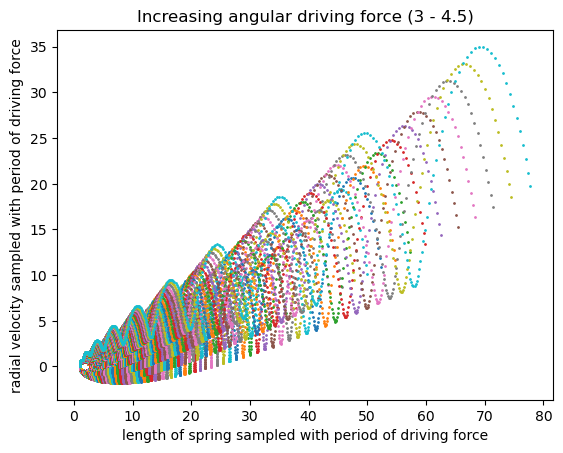

In [486]:
## testing sampling
initial_conditions = np.array([1, 0, 0, 0])
step_count = 1000
step_size = .01
t = np.linspace(0, step_count * step_size, step_count)

F_angular = np.linspace(3, 4.5, 100)
omega_angular = np.pi
sample_period = int(2 * np.pi / omega_angular) # best to make sure this is a round num

final_r = np.zeros(len(F_angular))
final_r_dot = np.zeros(len(F_angular))
final_theta = np.zeros(len(F_angular))
final_theta_dot = np.zeros(len(F_angular))

i = 0
for F in F_angular:
    r, theta, r_dot, theta_dot = elastic_pendulum_bash(initial_conditions, .01, step_count, step_size, 0, 0, F, 0, omega_angular, 0)

    sampled_r = r[::sample_period]
    sampled_r_dot = r_dot[::sample_period]
    
    plt.scatter(sampled_r[:-1], sampled_r_dot[:-1], s = 1)
    
    final_theta[i] = theta[-2] # using second to last because adams bashforth last val is position of pendulum
    final_theta_dot[i] = theta_dot[-2]
    final_r[i] = r[-2] # using second to last because adams bashforth last val is position of pendulum
    final_r_dot[i] = r_dot[-2]
    i += 1

plt.xlabel("length of spring sampled with period of driving force")
plt.ylabel("radial velocity sampled with period of driving force")
plt.title("Increasing angular driving force (3 - 4.5)")
plt.show()

here we can see the change in shape that occurs in the periodically sampled data. We see that once the driving force has an amplitude ~3, the length and radial velocity both shoot up to large numbers while still maintaining some oscillations.

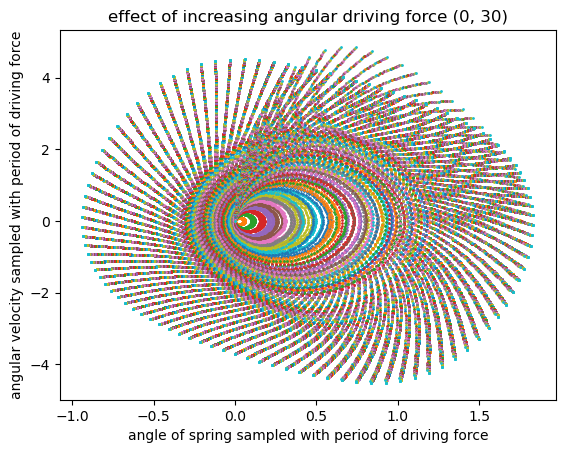

In [482]:
initial_conditions = np.array([1, 0, 0, 0])
step_count = 1000
step_size = .01
t = np.linspace(0, step_count * step_size, step_count)
F_angular = np.linspace(0, 30, 100)
omega_angular = np.pi
sample_period = int(2 * np.pi / omega_angular) # best to make sure this is a round num

final_theta = np.zeros(len(F_angular))
final_theta_dot = np.zeros(len(F_angular))

i = 0
for F in F_angular:
    r, theta, r_dot, theta_dot = elastic_pendulum_bash(initial_conditions, .01, step_count, step_size, 0, 0, F, 0, omega_angular, 0)

    sampled_theta = theta[::sample_period]
    sampled_theta_dot = theta_dot[::sample_period]
    plt.scatter(sampled_theta[:-1], sampled_theta_dot[:-1], s = 1)

    final_theta[i] = sampled_theta[-2]
    final_theta_dot[i] = sampled_theta_dot[-2]
    i += 1


plt.xlabel("angle of spring sampled with period of driving force")
plt.ylabel("angular velocity sampled with period of driving force")
plt.title("effect of increasing angular driving force (0, 30)")
plt.show()

here we can see that effect of the angular driving force on the angle and angular velocity of the spring. What we can see here is that as the magnitude of the driving force increases, the sape of the data changes from being roughly circular to falling out of phase as the angular driving force gets obscurely large.

In [539]:
def find_chaos(step_count, step_size, angular_velocity, F_theta, F_r, omega_angular, omega_r, gamma):
    """
    displays 5 graphs based on parameters that help me identify what IC cause chaos

    step_count : number of time steps
    step_size : size of each step being taken
    angular_velocity : the range of angular velocities we are looking at
    F_theta : maximum amount of periodic angular driving force
    F_r : maximum amount of periodic radial driving force
    omega_angular : the frequency of the angular driving force
    omega_r : the frequency of the radial driving force
    gamma : parameter that relates the strength of gravity to the stength of the spring

    returns : Various figures used to identify the presence of chaos
    """
    final_theta1 = np.zeros(len(angular_velocity))
    final_theta_dot1 = np.zeros(len(angular_velocity))
    final_r1 = np.zeros(len(angular_velocity))
    final_r_dot1 = np.zeros(len(angular_velocity))
    t_vals = np.linspace(0, step_size * step_count, step_count + 1)
    
    i = 0
    for velo in angular_velocity:
        initial_conditions = np.array([1, np.pi/4, 0, velo])
        
        r1, theta1, r_dot1, theta_dot1 = elastic_pendulum_bash(initial_conditions, .01, step_count, step_size, 0, 0, F_theta, F_r, omega_angular, omega_r)
        plt.plot(t_vals, r1)
        final_r1[i] = r1[-2]
        final_r_dot1[i] = r_dot1[-2]
        final_theta1[i] = theta1[-2]
        final_theta_dot1[i] = theta_dot1[-2]
        i += 1

    plt.ylim(-5, 5)
    plt.xlabel("time")
    plt.ylabel("length of spring")
    plt.title(f"length of spring for initial angular velocity b/w {angular_velocity[0]} - {angular_velocity[-1]}")
    plt.show()
    plt.plot(angular_velocity, final_r_dot1)
    plt.xlabel("initial angular velocity")
    plt.ylabel("radial velocity of spring")
    plt.title("Bash")
    plt.show()
    plt.plot(angular_velocity, final_r1)
    plt.xlabel("initial angular velocity")
    plt.ylabel("final length of spring")
    plt.title("Bash")
    plt.show()
    plt.plot(angular_velocity, final_theta1)
    plt.xlabel("initial angular velocity")
    plt.ylabel("angular velocity of spring")
    plt.title("Bash")
    plt.show()
    plt.plot(angular_velocity, final_theta_dot1)
    plt.xlabel("initial angular velocity")
    plt.ylabel("final angle of spring")
    plt.title("Bash")
    plt.show()

This function and its applications below aim to find chaotic or interesting sets of conditions by showing velocity vs various position variables and by showing plots of time vs length of the spring (with all of the angular velocities).

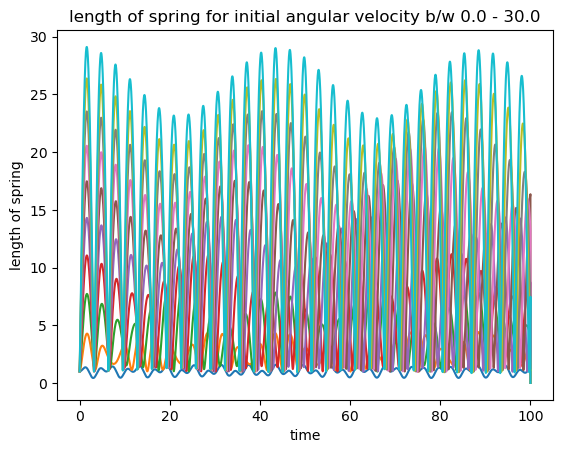

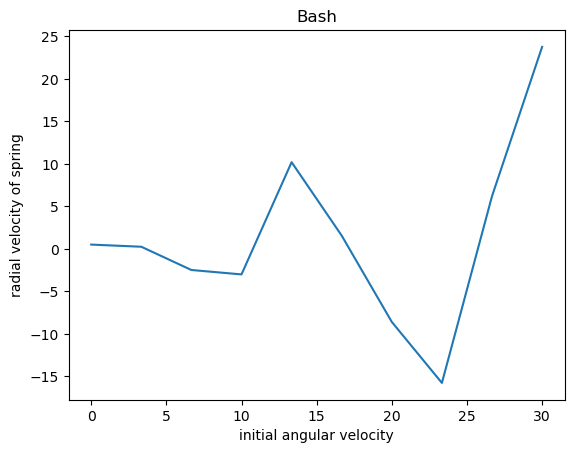

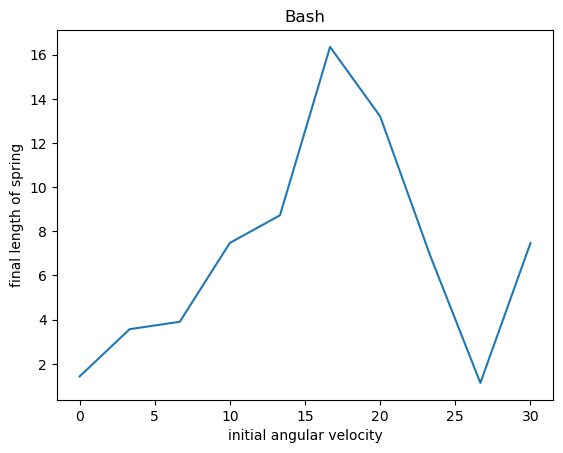

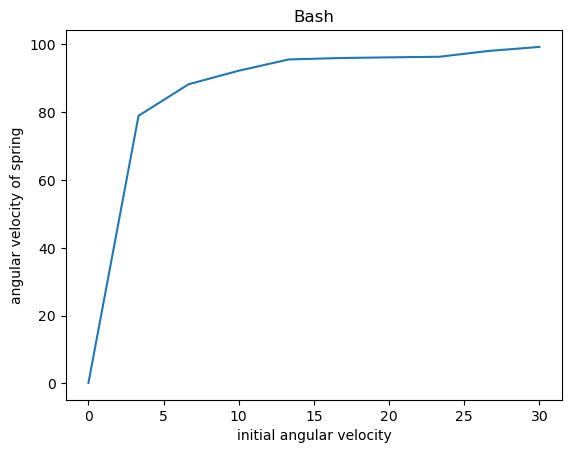

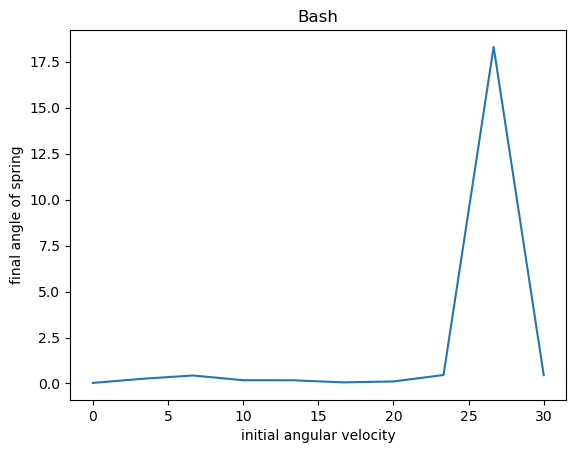

In [515]:
angular_velocity = np.linspace(0, 30, 10)
F = 1
omega_r = np.pi / 1.5
step_count = 10000
step_size = .01

find_chaos(step_count, step_size, angular_velocity, 0, F, 0, omega_r, .01)

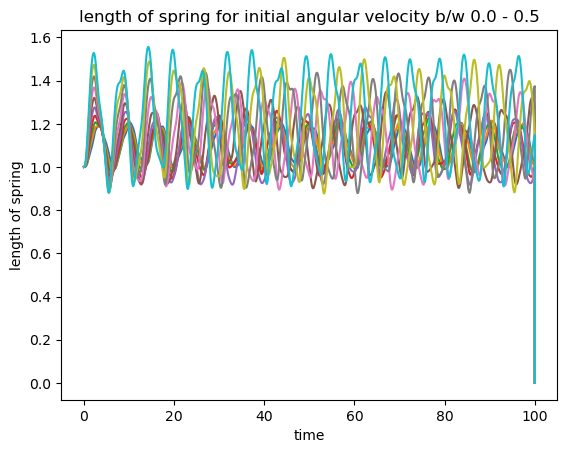

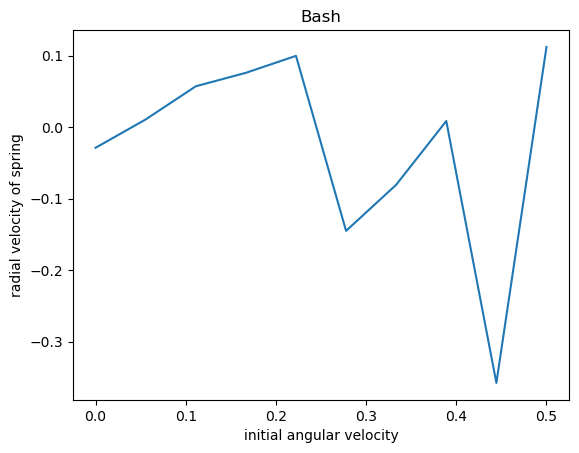

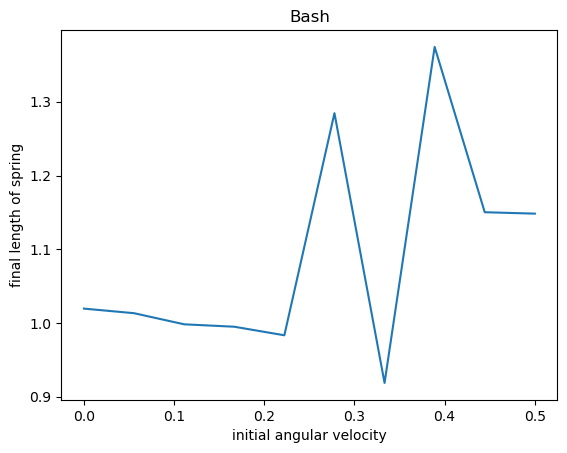

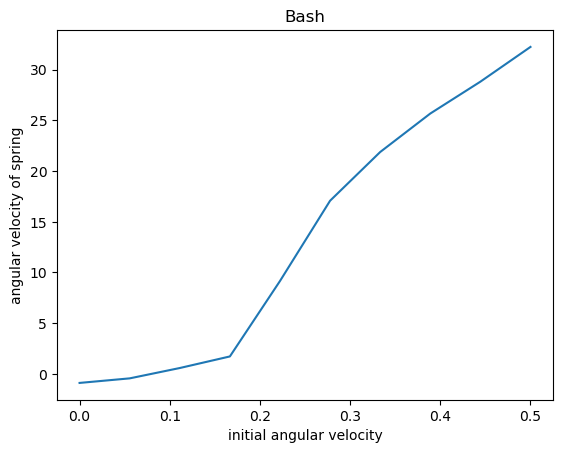

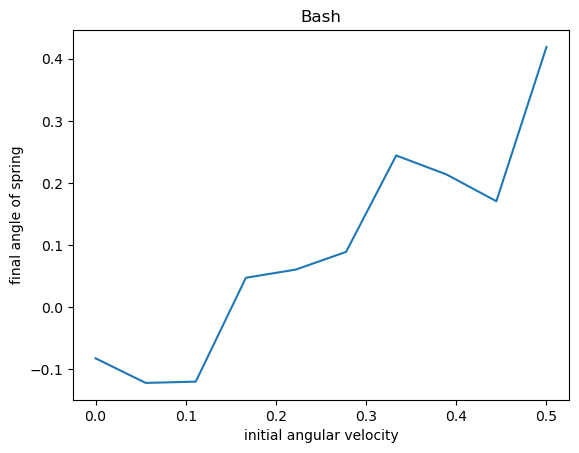

In [517]:
angular_velocity = np.linspace(0, .5, 3)
F = 1
omega_angular = np.pi / 1.25
step_count = 10000
step_size = .01

find_chaos(step_count, step_size, angular_velocity, F, 0, omega_angular, 0, .01)

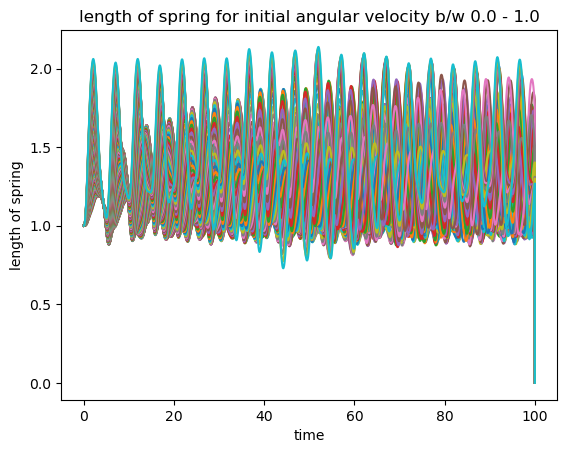

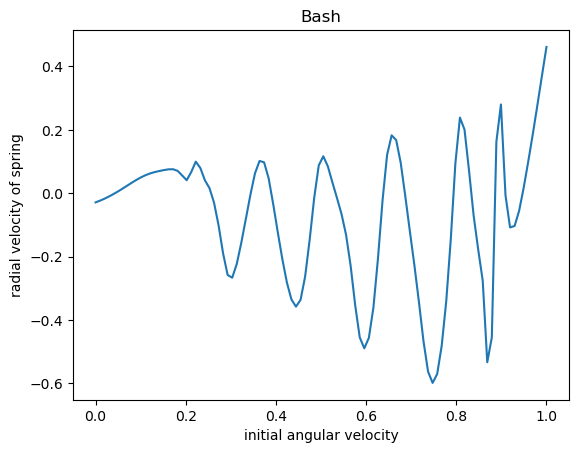

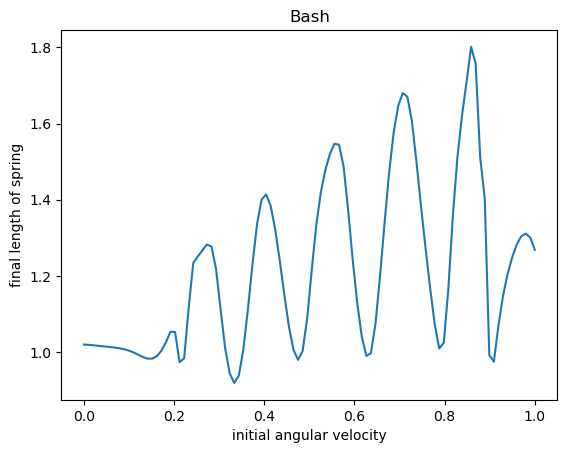

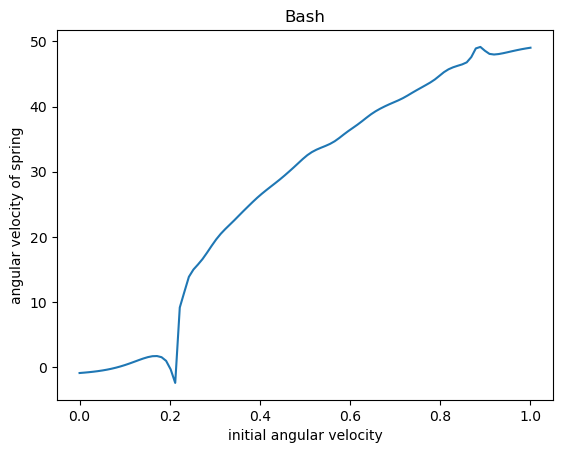

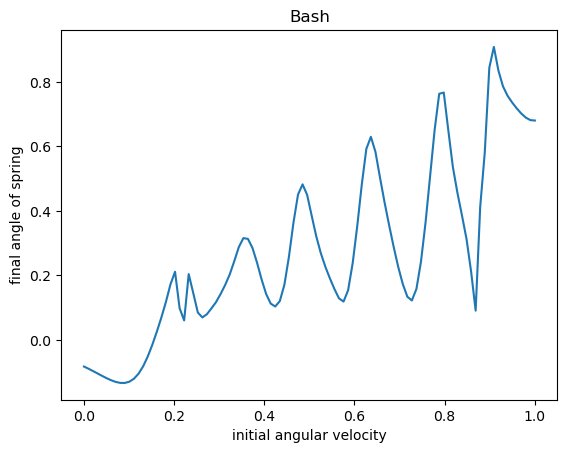

In [533]:
angular_velocity = np.linspace(0, 1, 100)
F = 1
omega_angular = np.pi / 1.25
step_count = 10000
step_size = .01

find_chaos(step_count, step_size, angular_velocity, F, 0, omega_angular, 0, .01)

/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_63520/3503215092.py:28: RuntimeWarning: overflow encountered in scalar multiply
  radial_acceleration = ((x[0]) * (x[3]**2)) + (1 - x[0]) + (gamma * np.cos(x[1])) - (C_2 * x[1]) + (F_2 * np.cos(omega_r * t))
/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_63520/3503215092.py:29: RuntimeWarning: overflow encountered in scalar multiply
  angular_acceleration = ((-gamma/x[0]) * np.sin(x[1])) - (2 * x[3] * x[2] / x[0]) - (C_1 * x[3]) + (F_1 * np.cos(omega_theta * t))
/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_63520/3503215092.py:29: RuntimeWarning: invalid value encountered in scalar multiply
  angular_acceleration = ((-gamma/x[0]) * np.sin(x[1])) - (2 * x[3] * x[2] / x[0]) - (C_1 * x[3]) + (F_1 * np.cos(omega_theta * t))
/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_63520/3886108253.py:31: RuntimeWarning: invalid value encountered in subtract
  f_vals[i+1] = f_vals[i] + ((step_size / 2.0) * 

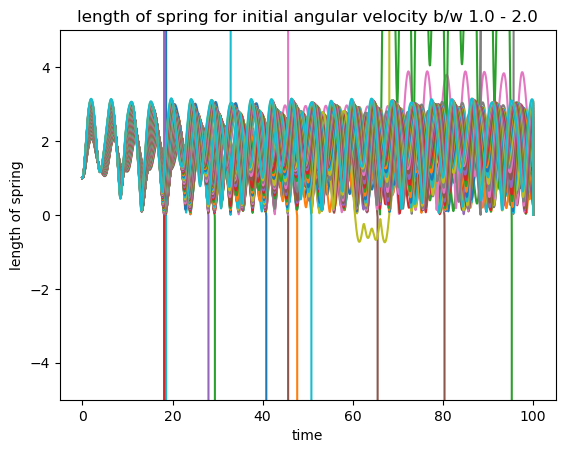

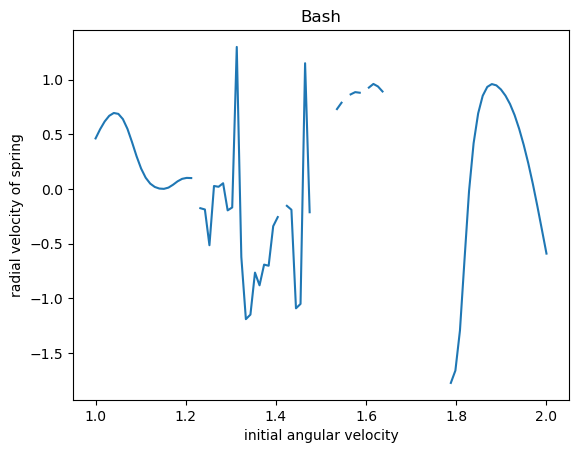

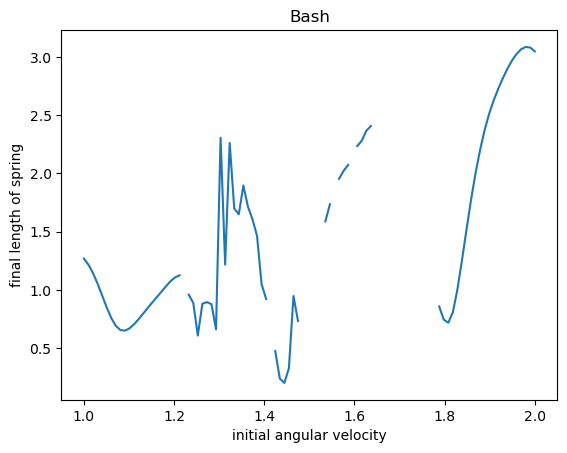

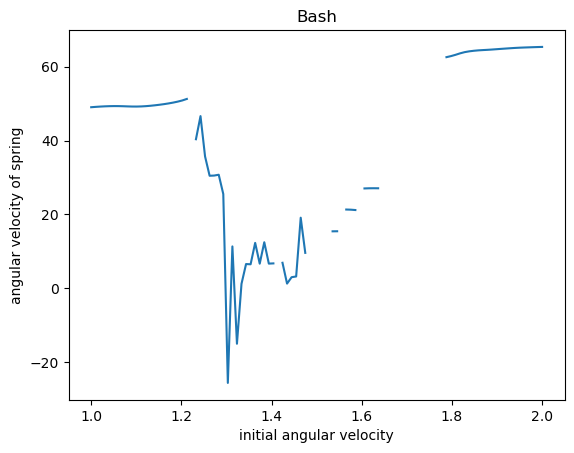

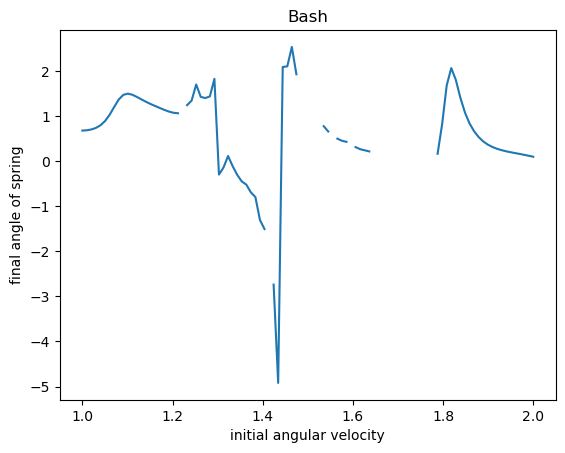

In [543]:
angular_velocity = np.linspace(1, 2, 100)
F = 1
omega_angular = np.pi / 1.25
step_count = 10000
step_size = .01

find_chaos(step_count, step_size, angular_velocity, F, 0, omega_angular, 0, .01)

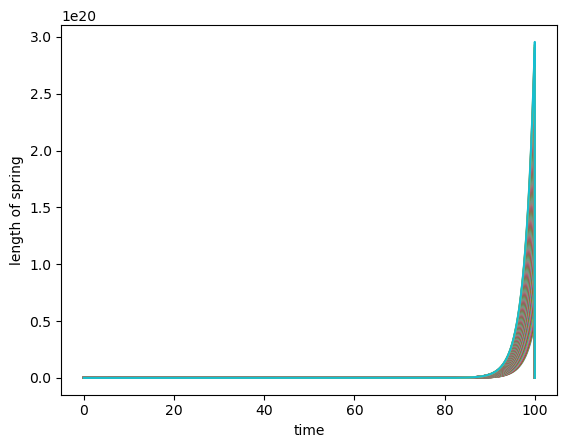

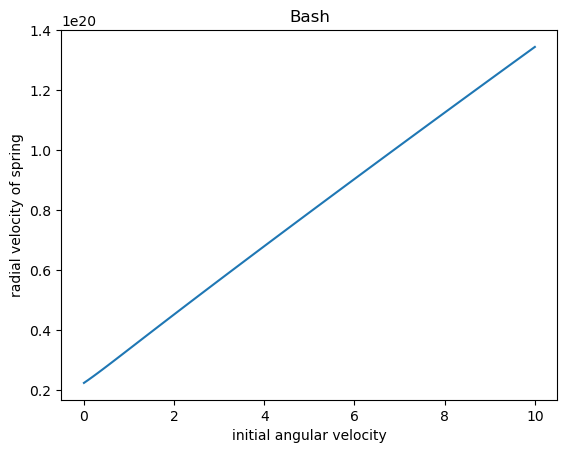

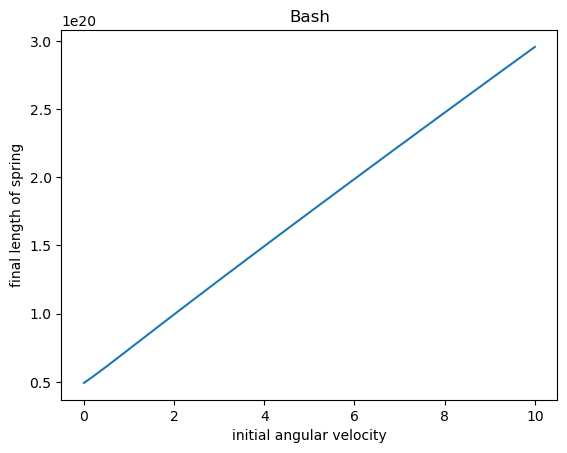

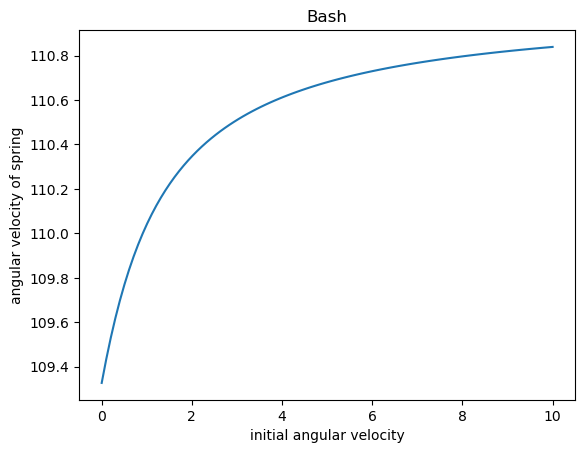

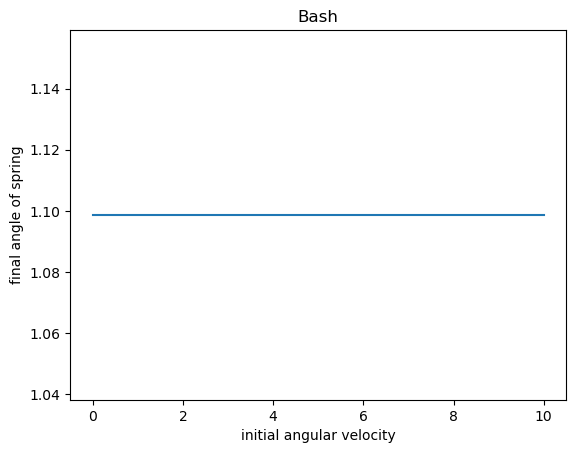

In [488]:
angular_velocity = np.linspace(0, 10, 100)
gamma = .01
F = 1
omega_angular = 0
step_count = 10000
step_size = .01

find_chaos(step_count, step_size, angular_velocity, F, 0, omega_angular, 0)

In [446]:
def find_chaos2(step_count, step_size, angular_velocity, F_theta, omega_angular):
    """
    displays 4 graphs based on parameters that help me identify what IC cause chaos

    step_count : number of time steps
    step_size : size of each step being taken
    angular_velocity : singular angular velocity
    F_theta : list of angular driving forces
    omega_angular : the frequency of the angular driving force
    """
    final_theta1 = np.zeros(len(F_theta))
    final_theta_dot1 = np.zeros(len(F_theta))
    final_r1 = np.zeros(len(F_theta))
    final_r_dot1 = np.zeros(len(F_theta))
    t_vals = np.linspace(0, step_size * step_count, step_count + 1)
    
    i = 0
    for F in F_theta:
        initial_conditions = np.array([1, 0, 0, angular_velocity])
        
        r1, theta1, r_dot1, theta_dot1 = elastic_pendulum_bash(initial_conditions, .01, step_count, step_size, 0, 0, F, 0, omega_angular, 0)
        final_r1[i] = r1[-2]
        final_r_dot1[i] = r_dot1[-2]
        final_theta1[i] = theta1[-2]
        final_theta_dot1[i] = theta_dot1[-2]
        i += 1

    plt.plot(F_theta, final_r_dot1)
    plt.xlabel("initial driving force")
    plt.ylabel("final radial velocity of spring")
    plt.title("Bash")
    plt.ylim()
    plt.show()
    plt.plot(F_theta, final_r1)
    plt.xlabel("initial driving force")
    plt.ylabel("final length of spring")
    plt.title("Bash")
    plt.show()
    plt.plot(F_theta, final_theta1)
    plt.xlabel("initial driving force")
    plt.ylabel("final angle of spring")
    plt.title("Bash")
    plt.show()
    plt.plot(F_theta, final_theta_dot1)
    plt.xlabel("initial driving force")
    plt.ylabel("final anglular velocity of spring")
    plt.title("Bash")
    plt.show()

This is the second iteration of the chaos finding function however the difference is that this function looks at some range of driving forces in order to find the chaos with only a singular angular velocity parameter.

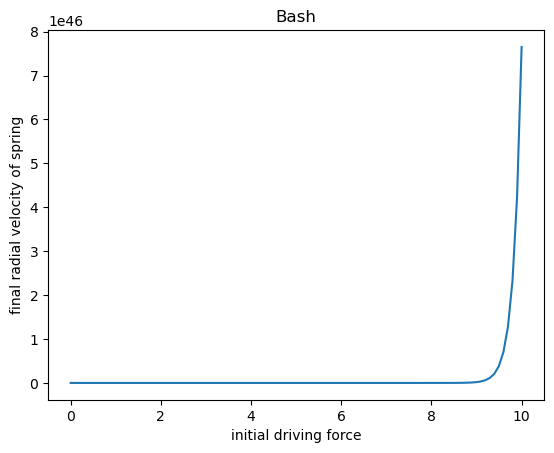

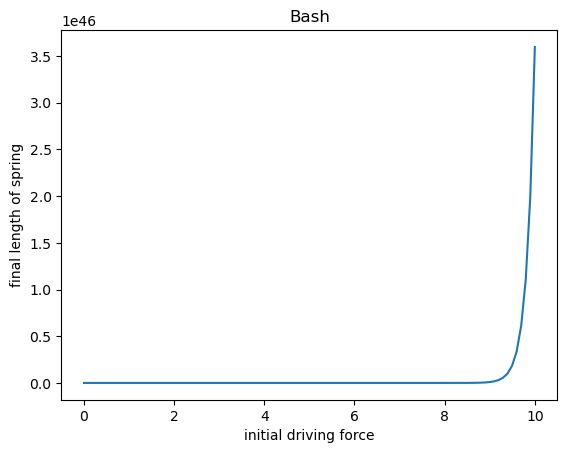

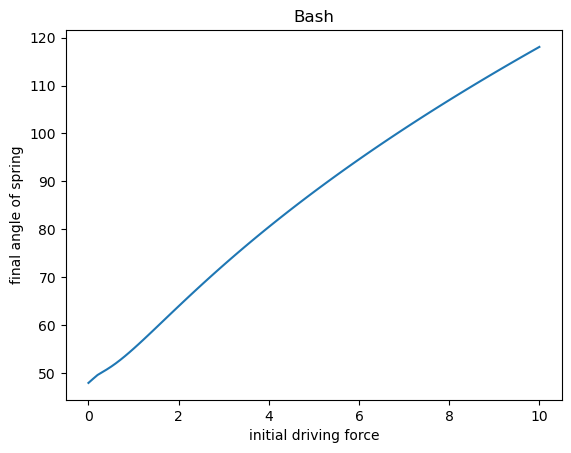

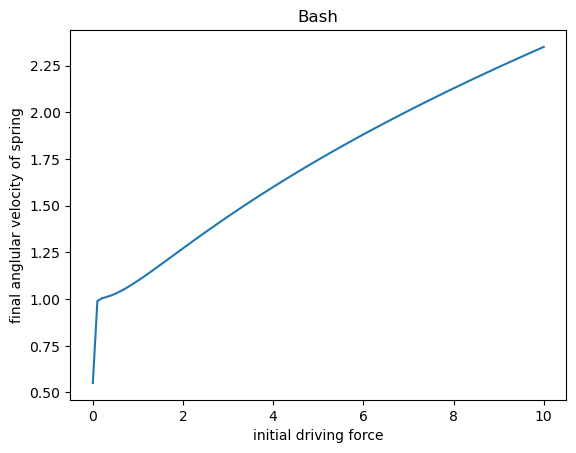

In [448]:
angular_velocity = 10
F_theta = np.linspace(0, 10, 100)
omega_r = np.pi / 1.5
step_count = 5000
step_size = .01

find_chaos2(step_count, step_size, angular_velocity, F_theta, omega_angular)

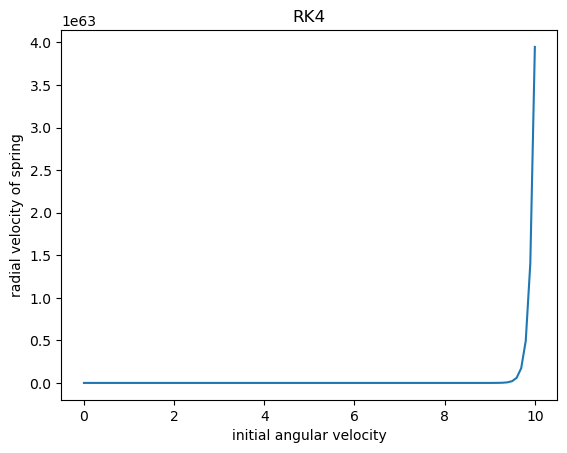

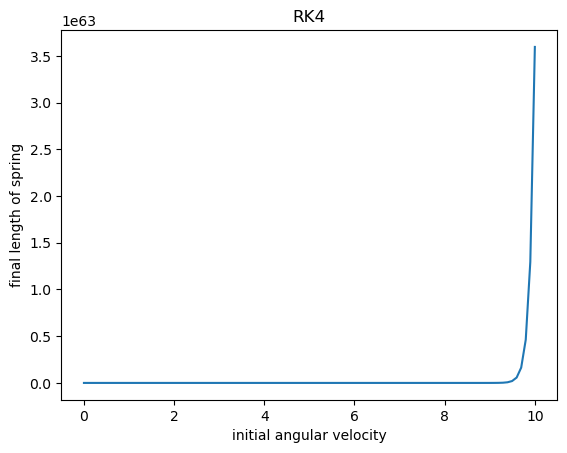

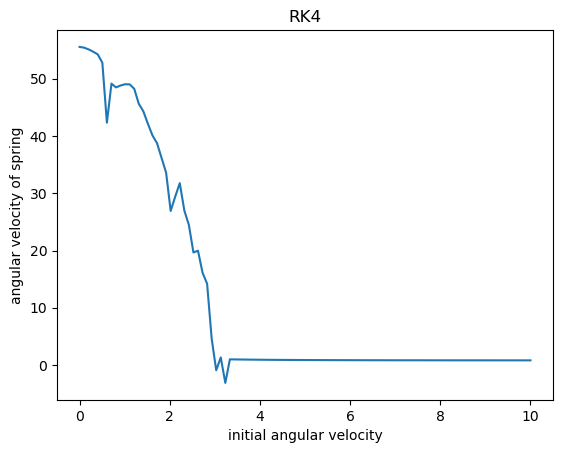

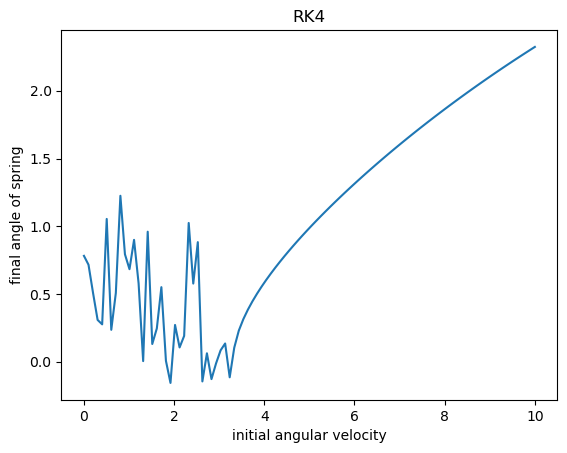

In [262]:
angular_velocity = 1
F_theta = np.linspace(0, 10, 100)
omega_r = np.pi / 1.5
step_count = 10000
step_size = .01

find_chaos2(step_count, step_size, angular_velocity, F_theta, omega_angular)

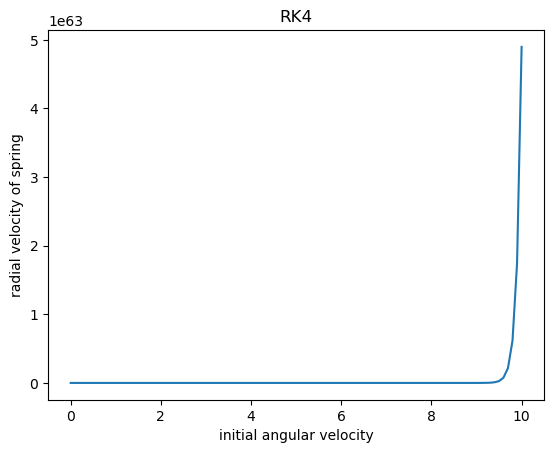

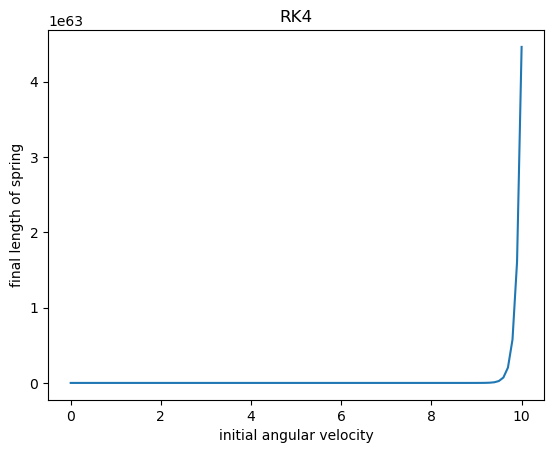

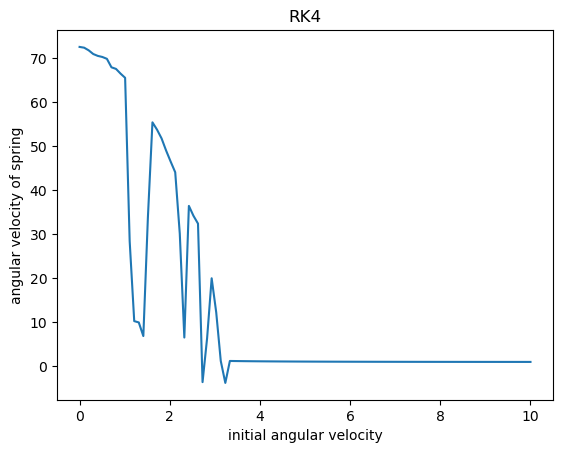

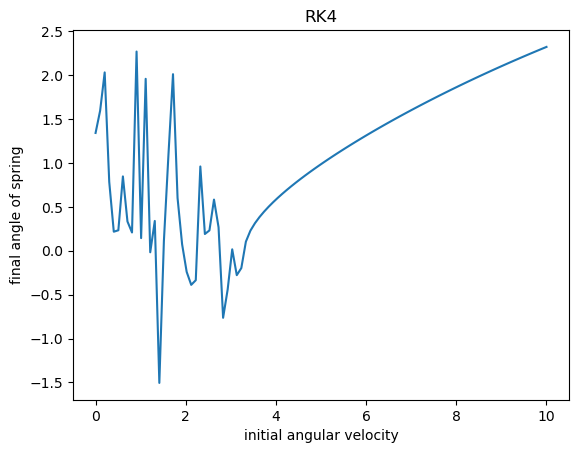

In [263]:
angular_velocity = 2
F_theta = np.linspace(0, 10, 100)
omega_r = np.pi / 1.5
step_count = 10000
step_size = .01

find_chaos2(step_count, step_size, angular_velocity, F_theta, omega_angular)

/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_63520/4189786173.py:57: RuntimeWarning: overflow encountered in scalar power
  radial_acceleration = ((x[0]) * (x[3]**2)) + (1 - x[0]) + (gamma * np.cos(x[1])) - (C_2 * x[1]) + (F_2 * np.cos(omega_r * t))
/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_63520/4189786173.py:58: RuntimeWarning: overflow encountered in scalar multiply
  angular_acceleration = ((-gamma/x[0]) * np.sin(x[1])) - (2 * x[3] * x[2] / x[0]) - (C_1 * x[3]) + (F_1 * np.cos(omega_theta * t))
/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_63520/4189786173.py:58: RuntimeWarning: invalid value encountered in scalar multiply
  angular_acceleration = ((-gamma/x[0]) * np.sin(x[1])) - (2 * x[3] * x[2] / x[0]) - (C_1 * x[3]) + (F_1 * np.cos(omega_theta * t))
/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_63520/4189786173.py:57: RuntimeWarning: invalid value encountered in cos
  radial_acceleration = ((x[0]) * (x[3]**2)) + (1 - x[0])

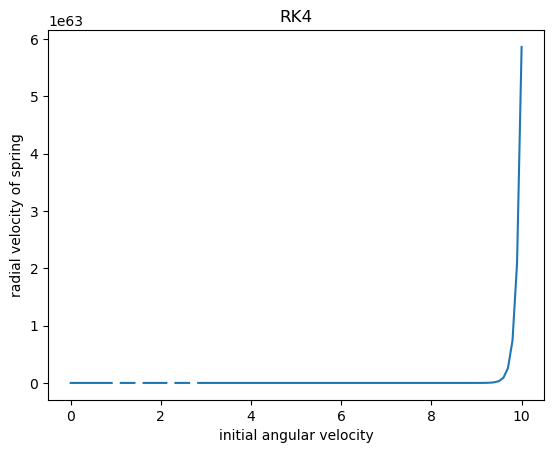

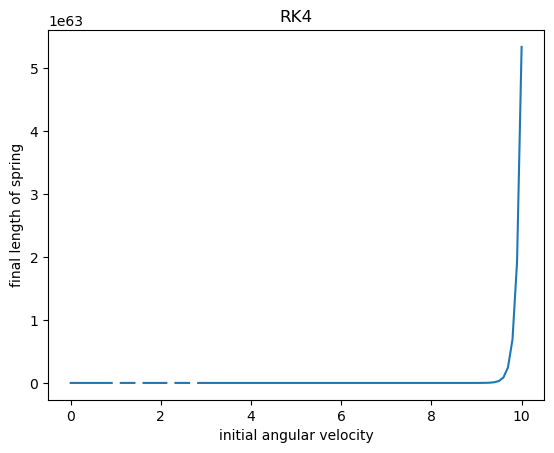

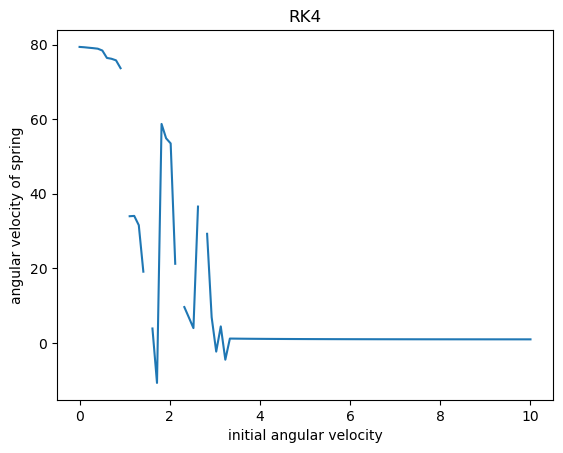

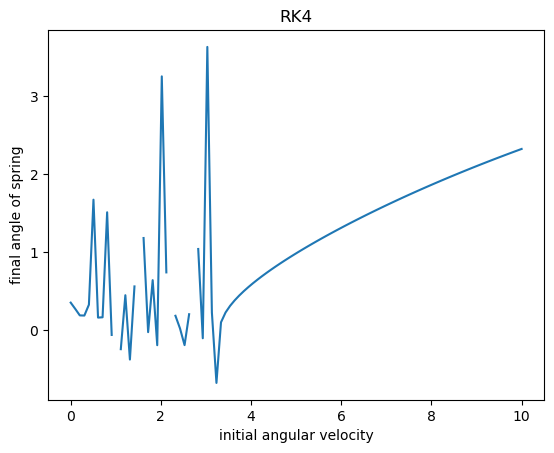

In [264]:
angular_velocity = 3
F_theta = np.linspace(0, 4, 100)
omega_r = np.pi / 1.5
step_count = 10000
step_size = .01

find_chaos2(step_count, step_size, angular_velocity, F_theta, omega_angular)